In [144]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyomo.environ as pyo
import random as rd
import copy 
import time

# Construction of $f_{CO_2}$

The CO2 emissions and the marginal cost due to those emissions for each energy source is listed below:



	
|Asset type | fuel | coal | gas  | nuclear | wind | solar | hydro | bioen |
|---|---|---|---|---|---|---|---|---|
|CO2 emissions rate gCO2eq./kWh | 777 | 986 | 429 | 0 | 0 | 0 | 0 | 494|
|Marginal cost euros/kWh | 162 | 86 | 70 | 30 | 0 | 0 | 0 | 0|

We now construct $$ f_{CO_2}$$ as explained. 

### !!!The capacity for each energy source must be adapted after getting the data!!!

In [136]:
#usual variables for testing purposes

power_sources = pd.DataFrame({'Source' :['dummy','fuel','coal','gas' ,'nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,20,10 ,0 ,0], 'Capacity': [0,20000,1500, 1000, 800, 200, 150, 100, 100 ]})
power_sources = power_sources.sort_values('Marginal cost').reset_index(drop = True)
power_sources['Marginal cost'][0]



0

In [145]:
def f_CO2 (Load, power_sources , unit = 'Marginal cost'):
    # Load = float,load 
    # unit = 'Marginal cost' or  'CO2 emissions', indicate if you want your result as the amount of CO2 emitted or the price that these emissions represent
    # power_sources 3xn np.array,  first row is the name of the power sources, second row their marginal cost, third row their capacity

    power_sources_copy = power_sources.sort_values([unit, 'Capacity']).reset_index(drop=True).copy() #rank from the least emitting to the worst one
    res = 0
    for i in power_sources.index: #as defined in the pdf
        try:
            res += (power_sources_copy[unit][i+1] - power_sources_copy[unit][i] )* max(Load - sum(power_sources_copy['Capacity'][:i+1]), 0)           
        except KeyError: # to do the convention P_0 = 0
            #print('exception happend in f_CO2')
            res += power_sources_copy[unit][i] * max(Load - sum(power_sources_copy['Capacity'][:i]), 0) # convention P_0 = 0
        except Exception as e:
            print('something went wrong in f_CO2')
            print(e)

    return res


        

    
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[-93302.91089109]
 [   101.31875188]]


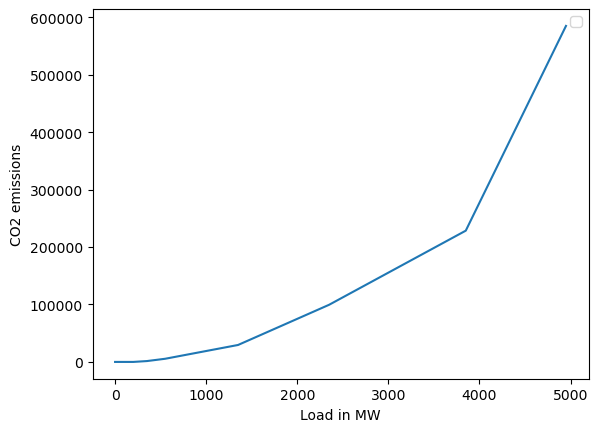

In [138]:
unit = 'CO2 emissions' #'Marginal cost'
power_sources = pd.DataFrame({'Source' :['dummy','fuel','coal','gas' ,'nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,20,10 ,0 ,0], 'Capacity': [0,2000,1500, 1000, 800, 200, 150, 100, 100 ]})

X = np.array([50 * i for i in range(100)])
Y = np.array([f_CO2(50 * i, power_sources=power_sources) for i in range(100)])


plt.plot(X,Y)

plt.xlabel('Load in MW')
plt.ylabel(unit)


# Given data
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

# Perform linear regression
X_b = np.c_[np.ones((len(X), 1)), X]  # Add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(Y)
print(theta_best)

# Make predictions using the fitted model
X_new = np.array([[1], [1000]])  # Use the range of X for prediction
X_new_b = np.c_[np.ones((2, 1)), X_new]
Y_predict = X_new_b.dot(theta_best)

# Plot the data and the linear regression line

#plt.plot(X_new, Y_predict, "r-", label="Linear Regression")

plt.legend()
plt.show()



## 2 - Optimization problems
### 2.A - Small optimization of one car

We want to solve the problem, for a certain car j: 
$$
min_{(l^{EV}_j(t))_{t=1,...,48}} [ \; \; \Sigma_{t=1}^{48} \; f_{CO_2}( \, l^{NF}(t) \, + \, \Sigma_{i \ne j} l^{EV}_i(t) \,  + \, l^{EV}_j(t)) ]; \; \; (l^{EV}_j(t))_{t=1,...,48} \in \mathcal{L_j} \\  \text{with: } \mathcal{L_j} \, = \, \{ (l^{EV}_j(t))_t \, : \, \text{for }  t \, \in \,  {a_j+1,..., d_j -1}, \, 0\leq l^{EV}_j(t) \leq 7, \, \text{else } l^{EV}_j(t) = 0, \, \Sigma^{d_j-1}_{t=a_j+1} \delta * l^{EV}_j(t) \, = \, e_j \}
$$

(with the same notation as in the report)

For this we use pyomo alongside the GLPK solver. 

In [139]:
model = pyo.ConcreteModel()#initialization of the model

power_needed_j = 50 #e_j /delta, for the constraints 
max_charging_capacity = 13
nb_time_slots = 6

time_slots =  [ i for i in range(nb_time_slots)] #generate the set of timeslots and other players, for now we assume that they all have the SAME TIMESLOTS

l_NF = [rd.randint(5,10) for _ in range(nb_time_slots-1)] + [20]#non flexible load for each time slots
#l_NF = [43 for i in range(nb_time_slots)]
#l_NF = [7 for _ in range(nb_time_slots)]

l_other_players = [[rd.randint(1,5) for _ in range(nb_time_slots)], [rd.randint(1,5) for _ in range(nb_time_slots)]]# (l(t_i))j, set of the load of one of the other players at a given time_slot
#l_other_players = [[0 for i in range(nb_time_slots)], [0 for i in range(nb_time_slots)]]
#l_other_players = [[4,1,3,8,8], [1,2,3,5,7]]
#here we declare the "variable", so the load we're allowed to schedule to do the minimzation
model.load_car = pyo.Var(time_slots, domain = pyo.NonNegativeReals)

In [140]:

###### Additional fictional constraints and variables to model f_CO2 in a linear programming way
unit = 'Marginal cost'
power_sources = pd.DataFrame({'Source' :['dummy','fuel','coal','gas ','nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,0,0 ,0 ,0], 'Capacity': [0,200,15, 20, 4, 1, 1, 1, 1 ]})
power_sources = power_sources.sort_values([unit, 'Capacity']).reset_index(drop = True)

P_tidle = power_sources['Capacity'].copy()


#P_tidle.index = P_tidle.index +1
#P_tidle = pd.concat([pd.Series([0]),P_tidle]) #prepend a 0 to avoid the case i_0 and thus the lambda starts at -1
for i in range(len(P_tidle)): #we want the cumulative capacity
    P_tidle[i] = sum(power_sources['Capacity'][:i+1])
P_tidle = pd.DataFrame(data= ([P_tidle] * len(time_slots)), index = [time_slots], columns=P_tidle.index )#transform into a matrix with for each row a specific timeslot
#I allow myself this non optimized matrix form as the dimensions are limited, timeslots <= 48 and len(P_tidle) ~ 8

#we now prepare the values to substract, by the same for loop I save the i_o^t for each time slot:
to_substract = pd.Series(data = [l_NF[t] + sum(l_other_players[i][t] for i in range(len(l_other_players))) for t in time_slots], index = P_tidle.index)

print(to_substract, 'load of the other players + non flexible')

P_tidle = P_tidle.sub(to_substract, axis= 0)

list_i_0 = []
for i,row in P_tidle.iterrows():
        P_tidle.iloc[i].loc[P_tidle.iloc[i]<=0] = 0
        list_i_0 += [len(P_tidle.iloc[i].loc[P_tidle.iloc[i]<=0])]

#creation of y_i and Lambda_i !! nb of variable different for each timeslot, 
model.domain_dummy = pyo.Set(initialize = [i for i in range (100)])

model.Y = pyo.Set(within = model.domain_dummy * model.domain_dummy , initialize = [(t,i) for t in time_slots for i in range(len(P_tidle.iloc[t]) -list_i_0[t]) ])
model.y_i = pyo.Var(model.Y, domain = pyo.Binary)

model.Lambda = pyo.Set(within = model.domain_dummy * model.domain_dummy , initialize = [(t,i) for t in time_slots for i in range(len(P_tidle.iloc[t]) - list_i_0[t] + 1) ])
model.lambda_i = pyo.Var(model.Lambda , domain=pyo.NonNegativeReals)


#now we define the new constraints associated:
model.cons = pyo.ConstraintList() 
for t in time_slots:
    #print(t)
    #print(P_tidle.iloc[t].loc[P_tidle.iloc[t]!=0])
    model.cons.add(model.load_car[t] == sum(model.lambda_i[t,j+1]*P_tidle.iloc[t].loc[P_tidle.iloc[t]!=0][j + list_i_0[t] ] for j in range(len(P_tidle.iloc[t].loc[P_tidle.iloc[t]!=0]))))
    #model.cons.add(constraint_1(t))
    model.cons.add(sum(model.y_i[t,j] for j in range(len(P_tidle.iloc[0]) -list_i_0[t])) == 1)
    model.cons.add(sum(model.lambda_i[t,j] for j in range(len(P_tidle.iloc[0]) -list_i_0[t] +1) ) == 1)
    for i in range(len(P_tidle.iloc[0]) -list_i_0[t]):
         model.cons.add(model.y_i[t,i] <= model.lambda_i[t,i] + model.lambda_i[t,i+1])



#############################################################################

print(list_i_0)
f_CO2_P = []#to avoid recomputing at each iteration
for i in range(len(power_sources['Capacity'])):
     f_CO2_P += [f_CO2(sum(power_sources['Capacity'][:i]), power_sources = power_sources)]
#f_CO2_P = [i for i in range(len(power_sources['Capacity']))]
print(f_CO2_P)
def function_to_min(m): # function to minimize
    print(sum(sum(m.lambda_i[t,len(P_tidle.iloc[0]) - list_i_0[t] -i] * f_CO2_P[-i-1]  for i in range(len(P_tidle.iloc[0]) - list_i_0[t] + 1) ) for t in time_slots))
    return sum(sum(m.lambda_i[t,len(P_tidle.iloc[0]) - list_i_0[t] +1 -i -1] * f_CO2_P[-i-1]  for i in range(len(P_tidle.iloc[0]) - list_i_0[t] + 1) ) for t in time_slots)

model.CO2_cost = pyo.Objective(rule=function_to_min) #defining the function to minimize

# we already have that everything must be positive so the two constraints we're left with is load_car \leq 7 (charging capacity constraint) 
# and Sum l(t) = power needed for car j, (demand satisfied)
def bound_charging (m,t, max_charging_capacity = max_charging_capacity):
    return m.load_car[t] <= max_charging_capacity
def demand_satisfied (m):
    return pyo.summation(m.load_car) == power_needed_j

model.charging_constraint = pyo.Constraint(time_slots, rule=bound_charging) #entering the constraints in the model
model.demand_constraint = pyo.Constraint(rule = demand_satisfied)

#model.pprint()
opt = pyo.SolverFactory('glpk')
results = opt.solve(model)
model.solutions.store_to(results)
#model.pprint()
print(model.load_car.extract_values())
print(results)


0    17
1    13
2    16
3    16
4    14
5    26
dtype: int64 load of the other players + non flexible
[6, 6, 6, 6, 6, 6]
[0, 0, 0, 0, 0, 0, 120, 1520, 2810]
2810*lambda_i[0,3] + 1520*lambda_i[0,2] + 120*lambda_i[0,1] + 0*lambda_i[0,0] + 2810*lambda_i[1,3] + 1520*lambda_i[1,2] + 120*lambda_i[1,1] + 0*lambda_i[1,0] + 2810*lambda_i[2,3] + 1520*lambda_i[2,2] + 120*lambda_i[2,1] + 0*lambda_i[2,0] + 2810*lambda_i[3,3] + 1520*lambda_i[3,2] + 120*lambda_i[3,1] + 0*lambda_i[3,0] + 2810*lambda_i[4,3] + 1520*lambda_i[4,2] + 120*lambda_i[4,1] + 0*lambda_i[4,0] + 2810*lambda_i[5,3] + 1520*lambda_i[5,2] + 120*lambda_i[5,1] + 0*lambda_i[5,0]
{0: 0.0, 1: 13.0, 2: 12.0, 3: 12.0, 4: 13.0, 5: 0.0}

Problem: 
- Name: unknown
  Lower bound: 455.428571428571
  Upper bound: 455.428571428571
  Number of objectives: 1
  Number of constraints: 43
  Number of variables: 48
  Number of nonzeros: 132
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
    

### 2.B Best response algorithm


In [146]:
def solve_P_j(power_needed_j , max_charging_capacity , nb_time_slots , l_other_players , l_NF , power_sources = pd.DataFrame({'Source' :['dummy','fuel','coal','gas ','nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,0,0 ,0 ,0], 'Capacity': [0,200,15, 20, 4, 1, 1, 1, 1 ]}), unit_order = 'Marginal cost', unit_opti = 'Marginal cost', f_CO2=f_CO2):
    model = pyo.ConcreteModel()#initialization of the model
    time_slots =  [ i for i in range(nb_time_slots)] #generate the set of timeslots and other players, for now we assume that they all have the SAME TIMESLOTS
    model.load_car = pyo.Var(time_slots, domain = pyo.NonNegativeReals)
    #print(l_other_players)
    #print('####################################################################################################################')
    ###### Additional fictional constraints and variables to model f_CO2 in a linear programming way
    unit = 'Marginal cost'
    power_sources = power_sources.sort_values([unit_order, 'Capacity']).reset_index(drop = True)
    P_tidle = copy.deepcopy(power_sources['Capacity'])
    #P_tidle.index = P_tidle.index +1
    #P_tidle = pd.concat([pd.Series([0]),P_tidle]) #prepend a 0 to avoid the case i_0 and thus the lambda starts at -1
    for i in range(len(P_tidle)): #we want the cumulative capacity
        P_tidle[i] = sum(power_sources['Capacity'][:i+1])
    P_tidle = pd.DataFrame(data= ([P_tidle] * len(time_slots)), index = [time_slots], columns=P_tidle.index )#transform into a matrix with for each row a specific timeslot
    #I allow myself this non optimized matrix form as the dimensions are limited, timeslots <= 48 and len(P_tidle) ~ 8

    #we now prepare the values to substract, by the same for loop I save the i_o^t for each time slot:
    to_substract = pd.Series(data = [l_NF[t] + sum(l_other_players[i][t] for i in range(len(l_other_players))) for t in time_slots], index = P_tidle.index)
    P_tidle = P_tidle.sub(to_substract, axis= 0)

    list_i_0 = []
    for i,row in P_tidle.iterrows():
            P_tidle.iloc[i].loc[P_tidle.iloc[i]<=0] = 0
            list_i_0 += [len(P_tidle.iloc[i].loc[P_tidle.iloc[i]<=0])]

    #creation of y_i and Lambda_i !! nb of variable different for each timeslot, 
    model.domain_dummy = pyo.Set(initialize = [i for i in range (100)])

    model.Y = pyo.Set(within = model.domain_dummy * model.domain_dummy , initialize = [(t,i) for t in time_slots for i in range(len(P_tidle.iloc[t]) -list_i_0[t]) ])
    model.y_i = pyo.Var(model.Y, domain = pyo.Binary)

    model.Lambda = pyo.Set(within = model.domain_dummy * model.domain_dummy , initialize = [(t,i) for t in time_slots for i in range(len(P_tidle.iloc[t]) - list_i_0[t] + 1) ])
    model.lambda_i = pyo.Var(model.Lambda , domain=pyo.NonNegativeReals)


    #now we define the new constraints associated:
    model.cons = pyo.ConstraintList() 

    for t in time_slots:
        model.cons.add(model.load_car[t] == sum(model.lambda_i[t,j+1]*P_tidle.iloc[t].loc[P_tidle.iloc[t]!=0][j + list_i_0[t] ] for j in range(len(P_tidle.iloc[t].loc[P_tidle.iloc[t]!=0]))))
        model.cons.add(sum(model.lambda_i[t,j] for j in range(len(P_tidle.iloc[0]) -list_i_0[t] +1) ) == 1)
        for i in range(len(P_tidle.iloc[0]) -list_i_0[t]):
            model.cons.add(model.y_i[t,i] <= model.lambda_i[t,i] + model.lambda_i[t,i+1])

    def constraint_y (m,t):
        if len(P_tidle.iloc[0]) -list_i_0[t] ==0:
            print ('INCREASE CAPACITY, MAXIMUM REACHED')
        return sum(m.y_i[t,j] for j in range(len(P_tidle.iloc[0]) -list_i_0[t])) == 1
    model.cons_y = pyo.Constraint(time_slots, rule=constraint_y)

    #############################################################################
    f_CO2_P = [[] for t in time_slots]#to avoid recomputing at each iteration
    for t in time_slots:
        for i in range(len(power_sources['Capacity'])):
            f_CO2_P[t] += [f_CO2(max(sum(power_sources['Capacity'][:i+1]), (l_NF[t] + sum(l_other_players[i][t] for i in range(len(l_other_players))) )), power_sources= power_sources, unit = unit_opti)]
 
    def function_to_min(m): # function to minimize                              here it s supposed to be -i-1
        return sum(sum(m.lambda_i[t,len(P_tidle.iloc[0]) - list_i_0[t] +1 -i -1] * f_CO2_P[t][-i-1]  for i in range(len(P_tidle.iloc[0]) - list_i_0[t] + 1) ) for t in time_slots)

    model.CO2_cost = pyo.Objective(rule=function_to_min, sense = pyo.minimize) #defining the function to minimize

    # we already have that everything must be positive so the two constraints we're left with is load_car \leq 7 (charging capacity constraint) 
    # and Sum l(t) = power needed for car j, (demand satisfied)
    def bound_charging (m,t, max_charging_capacity = max_charging_capacity):
        return m.load_car[t] <= max_charging_capacity
    def demand_satisfied (m):
        return pyo.summation(m.load_car) == power_needed_j

    model.charging_constraint = pyo.Constraint(time_slots, rule=bound_charging) #entering the constraints in the model
    model.demand_constraint = pyo.Constraint(rule = demand_satisfied)


    opt = pyo.SolverFactory('glpk')
    results = opt.solve(model) #for more info put tee = True
    model.solutions.store_to(results)
    #model.pprint()
    # print(results)
    return model.load_car.extract_values()



        

In [147]:
def BRD_charging (l_0, eps, K, list_nb_time_slots, power_needed , arr_times ,   max_charging_capacity = 13, l_NF = [rd.randint(0,500) for _ in range(48)] + [200] , power_sources = pd.DataFrame({'Source' :['dummy','fuel','coal','gas ','nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,0,0 ,0 ,0], 'Capacity': [0,200,15, 20, 4, 1, 1, 1, 1 ]}),unit_order = 'Marginal cost', unit_opti = 'Marginal cost'):
    nb_players = len(power_needed)
    prev_l = [[100 for _ in range(48)] for i in range(nb_players)] #indexed by [player][time slot]
    l = l_0
    k=0
    while (sum(sum((l[j][t] - prev_l[j][t])**2 for t in range(48)) for j in range(nb_players)) >= eps) and (((sum((f_CO2(sum((l[j][t]) for j in range(len(l_0))) + l_NF[t], power_sources=power_sources)) for t in range(48)) - sum(f_CO2(l_NF[t]+sum((prev_l[j][t]) for j in range(nb_players)), power_sources=power_sources) for t in range(48)))**2)>= eps): #the criterion for convergence are either that the load distribution is constant, either that the CO2 emitted is constant
        if k>K:
            print(f'max iteration K={K} reached')
            break
        k+=1
        prev_l = copy.deepcopy(l)# !!! check if that doesn't slow down too much the algo

        


        for player in range(len(l_0)):
            temp_other_players = l.copy()
            temp_other_players.pop(player)

            # try:
            #     print(f'iteration {k}/{K}, player {player}/{len(l_0)}, time taken = {end_temp - start_temp}', end='\n')
            # except:
            #     print(f'iteration {k}/{K}, player {player}/{len(l_0)}')
            #     print('except')
            # # print(f'iteration {k}/{K}, player {player}/{len(l_0)}', end='\r')
            
            if arr_times[player] + list_nb_time_slots[player] < 48: #case disjunction to deal with the limit at midnight (23:30 = last time slot whereas 00:00 is the first timeslot)
                temp_other_players = np.array(temp_other_players)[:,arr_times[player]+1: (arr_times[player] + list_nb_time_slots[player])] #slicing such that only the concerned time slots of the other players are selected
                start_temp= time.time()
                temp = list(solve_P_j(power_needed_j = power_needed[player], max_charging_capacity = max_charging_capacity, nb_time_slots = list_nb_time_slots[player]-1, l_other_players = temp_other_players , l_NF= l_NF[arr_times[player]+1: (arr_times[player] + list_nb_time_slots[player])], power_sources = power_sources, unit_order =unit_order, unit_opti = unit_opti).values())
                end_temp = time.time()
                if None in temp:
                    for i in range (len(temp_other_players)):
                        print(len(temp_other_players[i]), '    len   ')
                        print(sum(temp_other_players[i]), '       sum')
                    for t in range(len(temp_other_players[0])):
                        print(sum(np.array(temp_other_players)[:,t]))
                
                l[player][arr_times[player]+1: (arr_times[player] + list_nb_time_slots[player])] = temp
            else:
                temp_other_players = np.concatenate((np.array(temp_other_players)[:, arr_times[player]+1:] , np.array(temp_other_players)[:, : ((arr_times[player] + list_nb_time_slots[player])%48)] ), axis = 1) #slicing such that only the concerned time slots of the other players are selected
                temp_L_NF = l_NF[arr_times[player]+1:] + l_NF[: ((arr_times[player] + list_nb_time_slots[player])%48)]
                temp_load= list(solve_P_j(power_needed_j = power_needed[player], max_charging_capacity = max_charging_capacity, nb_time_slots = list_nb_time_slots[player]-1, l_other_players = temp_other_players , l_NF= temp_L_NF, power_sources = power_sources, unit_order =unit_order, unit_opti = unit_opti).values())
                l[player][: (arr_times[player] + list_nb_time_slots[player])%48] = temp_load[- ((arr_times[player] + list_nb_time_slots[player])%48):].copy() #time slots after midnight  
                l[player][arr_times[player]+1:] = temp_load[: 48 - arr_times[player]-1].copy()
        print('\n',sum(sum((l[j][t] - prev_l[j][t])**2 for t in range(48)) for j in range(len(l_0))), '- Squared sum diff load')
        print((sum((f_CO2(sum((l[j][t]) for j in range(len(l_0))) + l_NF[t], power_sources=power_sources)) for t in range(48)) - sum(f_CO2(l_NF[t]+sum((prev_l[j][t]) for j in range(len(l_0))), power_sources=power_sources) for t in range(48)))**2 , '- Squared sum diff f_CO2')
    print(k)
    return l

In [143]:
nb_players = 100

 #breaks ard 20
max_charging_capacity = 600
list_nb_time_slots = [24 for i in range(nb_players)]
power_needed = [30 for i in range(nb_players)] #why does 640 crash
#power_needed = [5000 , 5000]
unit_opti = 'Marginal cost'
unit_order = 'Marginal cost'
power_sources = pd.DataFrame({'Source' :['dummy','fuel','coal','gas' ,'nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,20,10 ,0 ,0], 'Capacity': [0,20000,1100, 300, 150, 80,80, 100,100]})
#l_NF = [rd.randint(0,800) for _ in range(48)] 
l_NF = [164, 447, 693, 206, 169, 767, 186, 656, 152, 766, 731, 193, 647, 58, 382, 691, 224, 255, 475, 241, 796, 39, 197, 138, 305, 776, 705, 741, 643, 607, 626, 498, 1, 542, 248, 3, 361, 538, 705, 94, 414, 622, 291, 405, 443, 577, 435, 716] #randomly generated
#l_NF = [i for i in range(48)]

print(l_NF, 'NON FLEXIBLE LOAD')
l_0  = [[0 for _ in range(48)] for i in range(nb_players)]
arr_times = [0 for i in range(nb_players)]
eps = 1
K= 100

res = BRD_charging(l_0=l_0, eps=eps, K=K, arr_times= arr_times, list_nb_time_slots= list_nb_time_slots ,l_NF= l_NF, power_needed=power_needed, max_charging_capacity= max_charging_capacity ,power_sources= power_sources, unit_opti=unit_opti, unit_order = unit_order)
#res = [list(solve_P_j(power_needed_j = 9000, max_charging_capacity = max_charging_capacity, nb_time_slots = 23, l_other_players = [[0 for i in  range(23)]] , l_NF= l_NF, power_sources = power_sources, unit_order =unit_order, unit_opti = unit_opti).values())]
print(res)

[164, 447, 693, 206, 169, 767, 186, 656, 152, 766, 731, 193, 647, 58, 382, 691, 224, 255, 475, 241, 796, 39, 197, 138, 305, 776, 705, 741, 643, 607, 626, 498, 1, 542, 248, 3, 361, 538, 705, 94, 414, 622, 291, 405, 443, 577, 435, 716] NON FLEXIBLE LOAD


KeyboardInterrupt: 

C:\Users\thoma\AppData\Local\Temp\ipykernel_20104\1158690937.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_loads=np.sum(np.array(res[i]) for i in range(nb_players))


49680.0


Text(0.5, 1.0, 'nb_players = 100 , max_charging_capacity = 600, power needed around  30,arrival times around 0')

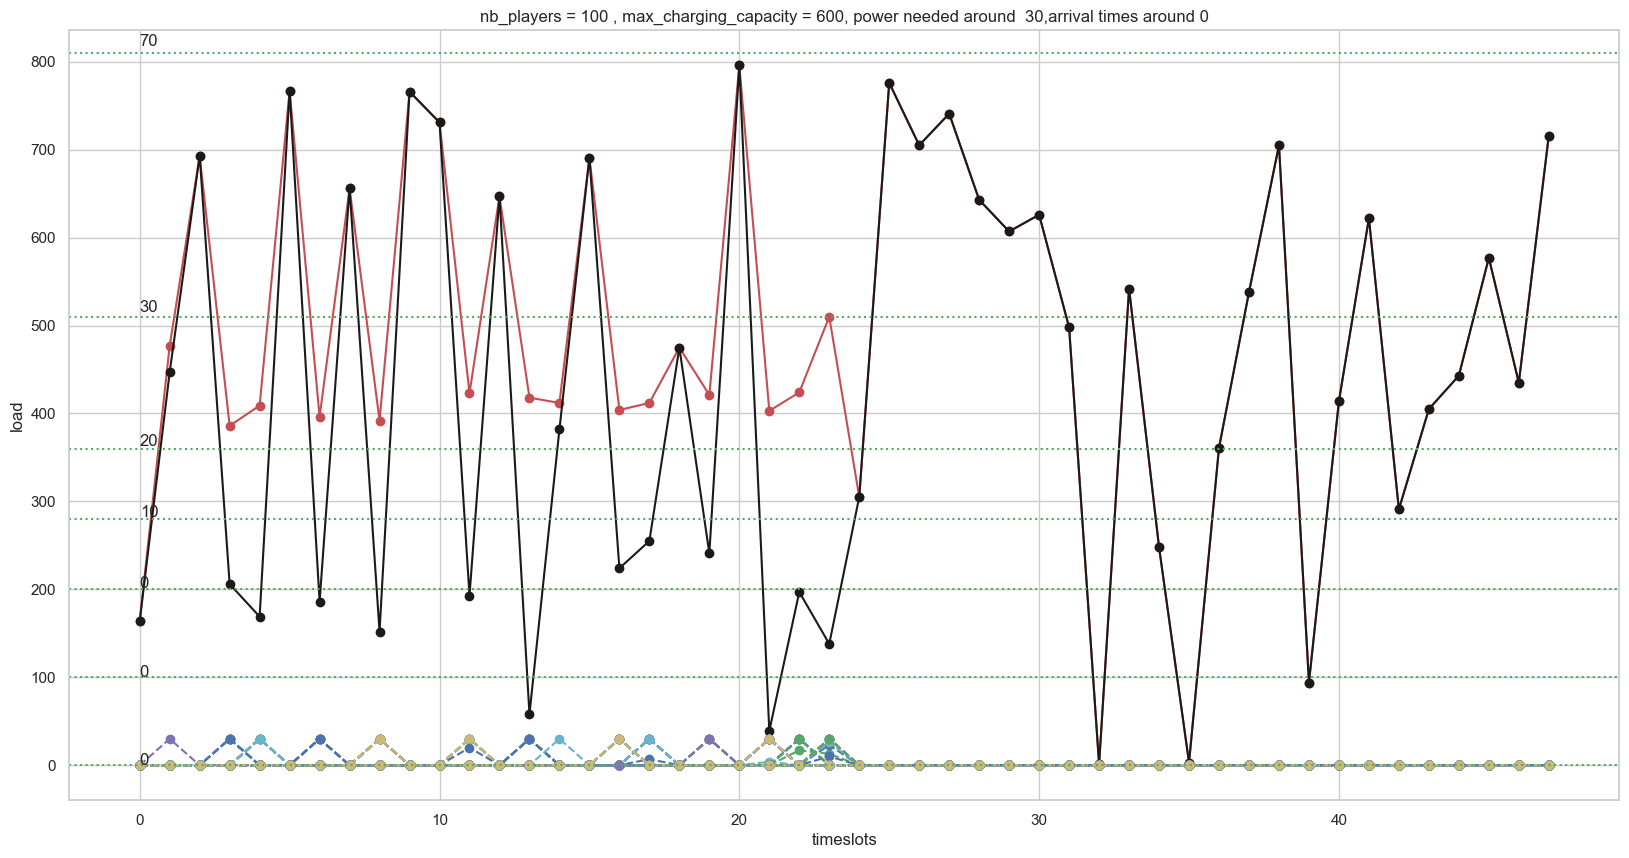

In [ ]:
#some visualization

sum_loads=np.sum(np.array(res[i]) for i in range(nb_players))
sum_loads = sum_loads + np.array(l_NF)
print(sum(f_CO2(sum_loads[t], power_sources= power_sources, unit= unit_opti) for t in range(len(res[0]))) - sum(f_CO2(l_NF[t], power_sources= power_sources, unit= unit_opti) for t in range(len(res[0]))))
color_bank=[ 'g', 'b','c','m','y']
X = [i for i in range(48)]

fig = plt.figure()

fig.set_figwidth(20)
fig.set_figheight(10)

plt.plot(X, sum_loads, label='total load', marker='o', color='r', linestyle='-')
plt.plot(X, l_NF,label = 'non flexible', marker='o', color='k', linestyle='-')
for i in range(len(res)):
    plt.plot(X,res[i], label = 'Player ' +str(i), marker='o', color=color_bank[i % len(color_bank)], linestyle='--')
plt.xlabel('timeslots')
plt.ylabel('load')
#plt.legend()
power_sources = power_sources.sort_values([unit, 'Capacity']).reset_index(drop = True)
temp = copy.deepcopy(power_sources['Capacity'])
for i in range(len(temp)): #we want the cumulative capacity
        temp[i] = sum(power_sources['Capacity'][:i+1])
for i in range(len(temp[:-2])):
    plt.axhline(temp[i], linestyle=':', color ='g')
    plt.text(0, temp[i] * 1.01, str(power_sources['Marginal cost'][i]))
plt.title(f'nb_players = {nb_players} , max_charging_capacity = {max_charging_capacity}, power needed around  {sum(power_needed)//len(power_needed)},arrival times around {sum(arr_times)//len(arr_times)}')
#plt.ylim(0,1300)
#plt.show()



# Trials with Data


In [148]:
#load the data
scenarios =pd.read_csv('.\data\ev_scenarios.csv', sep=';')
L_2020_winter = pd.read_csv('.\data\eCO2mix_RTE_Annuel-Definitif_2020_winter.csv', sep=';')
L_2020_summer = pd.read_csv('.\data\eCO2mix_RTE_Annuel-Definitif_2020_summer.csv', sep=';')
L_2019_winter = pd.read_csv('.\data\eCO2mix_RTE_Annuel-Definitif_2019_winter.csv', sep=';')
L_2019_summer = pd.read_csv('.\data\eCO2mix_RTE_Annuel-Definitif_2019_summer.csv', sep=';')


In [149]:
scenarios_arr_times = np.array(scenarios['time_slot_arr'].tolist()) -1
scenarios_dep_times = np.array(scenarios['time_slot_dep'].tolist())- 1
scenarios_time_slots = 48 - scenarios_arr_times + scenarios_dep_times
scenarios_energy_needed = np.array(scenarios['energy_need (kWh)'])

L_NF_summer = []
for i in range(24):#L_NF_summer is the average per time slot of L_NF_summer over one month 
    if i <= 9:
        L_NF_summer.append(1000*0.5*0.5*(L_2020_summer.loc[L_2020_summer['date'].str.contains( '0'+str(i) +':00'), 'consumption'].mean() + L_2019_summer.loc[L_2019_summer['date'].str.contains('0'+str(i)+ ':00'), 'consumption'].mean()))
        L_NF_summer.append(1000*0.5*0.5*(L_2020_summer.loc[L_2020_summer['date'].str.contains( '0'+str(i) +':30'), 'consumption'].mean() + L_2019_summer.loc[L_2019_summer['date'].str.contains('0'+str(i)+ ':30'), 'consumption'].mean()))
# we double it each time as we want 48 time slot instead of 24
    else:
        L_NF_summer.append(1000*0.5*0.5*(L_2020_summer.loc[L_2020_summer['date'].str.contains(str(i) +':00'), 'consumption'].mean() + L_2019_summer.loc[L_2019_summer['date'].str.contains(str(i)+ ':00'), 'consumption'].mean()))
        L_NF_summer.append(1000*0.5*0.5*(L_2020_summer.loc[L_2020_summer['date'].str.contains(str(i) +':30'), 'consumption'].mean() + L_2019_summer.loc[L_2019_summer['date'].str.contains(str(i)+ ':30'), 'consumption'].mean()))


L_NF_winter = []
for i in range(24):#L_NF_summer is the average per time slot of L_NF_summer over one month 
    if i <= 9:
        L_NF_winter.append(1000*0.5*0.5*(L_2020_winter.loc[L_2020_winter['date'].str.contains('0'+str(i) + ':00'), 'consumption'].mean() + L_2019_winter.loc[L_2019_winter['date'].str.contains('0'+str(i)+ ':00'), 'consumption'].mean()))
        L_NF_winter.append(1000*0.5*0.5*(L_2020_winter.loc[L_2020_winter['date'].str.contains('0'+str(i) + ':30'), 'consumption'].mean() + L_2019_winter.loc[L_2019_winter['date'].str.contains('0'+str(i)+ ':30'), 'consumption'].mean()))

    else:
        L_NF_winter.append(1000*0.5*0.5*(L_2020_winter.loc[L_2020_winter['date'].str.contains(str(i)+ ':00'), 'consumption'].mean() + L_2019_winter.loc[L_2019_winter['date'].str.contains(str(i)+ ':00'), 'consumption'].mean()))
        L_NF_winter.append(1000*0.5*0.5*(L_2020_winter.loc[L_2020_winter['date'].str.contains(str(i)+ ':30'), 'consumption'].mean() + L_2019_winter.loc[L_2019_winter['date'].str.contains(str(i)+ ':30'), 'consumption'].mean()))


len(L_NF_summer)



48

### Estimation of the capacities

1 st approach take max of the capacities in the data, taking the average between the 2 years, yielding for winter:


In [150]:
energy_sources = L_2020_winter.columns[4:]
capacities_winter= []
capacities_summer = []
for source in energy_sources:
    capacities_winter.append(1000*0.5*0.5*(L_2019_winter[energy_sources].abs().max( )[source] + L_2020_winter[energy_sources].abs().max()[source]))
    capacities_summer.append(1000*0.5*0.5*(L_2019_summer[energy_sources].abs().max()[source] + L_2020_summer[energy_sources].abs().max()[source]))
print(capacities_winter)
print(energy_sources)



power_sources_data_winter = pd.DataFrame({'Source' :['dummy','fuel','coal','gas ','nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,0,0 ,0 ,0], 'Capacity': [0] + capacities_winter[:-1]})
power_sources_data_summer = pd.DataFrame({'Source' :['dummy','fuel','coal','gas ','nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,0,0 ,0 ,0], 'Capacity': [0] + capacities_summer[:-1]})
power_sources_germany_cap = pd.DataFrame({'Source' :['dummy','fuel','coal','gas ','renewable' ,'other'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,100] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,0], 'Capacity': [0,1000*1165,1000* 19175, 1000*2568,1000* 33284,1000* 3234]})
print(power_sources_data_winter)

[756000.0, 734000.0, 4735750.0, 27782000.0, 6127750.0, 2063750.0, 1748000.0, 602250.0, 35250.0]
Index(['fuel', 'coal', 'gas', 'nuclear', 'wind', 'solar', 'hydro_pumping',
       'bioenergy', 'co2_rate'],
      dtype='object')
    Source  CO2 emissions  Marginal cost    Capacity
0    dummy              0              0         0.0
1     fuel            777            162    756000.0
2     coal            986             86    734000.0
3     gas             429             70   4735750.0
4  nuclear              0             30  27782000.0
5     wind              0              0   6127750.0
6    solar              0              0   2063750.0
7    hydro              0              0   1748000.0
8    bioen            494              0    602250.0


In [ ]:
nb_players = 3650
max_charging_capacity = 7
list_nb_time_slots = scenarios_time_slots
power_needed = scenarios_energy_needed
unit_opti = 'Marginal cost'
unit_order = 'Marginal cost'
power_sources = pd.DataFrame({'Source' :['dummy','fuel','coal','gas ','nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,0,0 ,0 ,0], 'Capacity': [0,2000000,15000, 29000, 8000, 2000, 800, 100, 100 ]})
l_NF = L_NF_summer
print(l_NF, 'NON FLEXIBLE LOAD')
l_0  = [[0 for _ in range(48)] for i in range(nb_players)]
# arr_times = scenarios_arr_times
arr_times = [0 for _ in range(len(scenarios_arr_times))]
eps = 100
K= 100

res = BRD_charging(l_0=l_0, eps=eps, K=K, arr_times= arr_times, list_nb_time_slots= list_nb_time_slots ,l_NF= l_NF, power_needed=power_needed, max_charging_capacity= max_charging_capacity ,power_sources= power_sources, unit_opti=unit_opti , unit_order=unit_order)

[43747.40486111111, 43747.40486111111, 40475.316666666666, 40475.316666666666, 39090.3, 39090.3, 36750.03333333333, 36750.03333333333, 35125.333333333336, 35125.333333333336, 34936.5, 34936.5, 35988.5, 35988.5, 39076.45, 39076.45, 42567.23333333334, 42567.23333333334, 45384.933333333334, 45384.933333333334, 47247.65, 47247.65, 48398.066666666666, 48398.066666666666, 49900.71666666667, 49900.71666666667, 50692.6, 50692.6, 48931.6, 48931.6, 47656.333333333336, 47656.333333333336, 46421.28333333333, 46421.28333333333, 45302.316666666666, 45302.316666666666, 45272.58333333333, 45272.58333333333, 46555.25, 46555.25, 45749.933333333334, 45749.933333333334, 43278.3, 43278.3, 42879.71666666667, 42879.71666666667, 46833.333333333336, 46833.333333333336] NON FLEXIBLE LOAD


KeyboardInterrupt: 

In [ ]:
#some visualization

sum_loads=np.sum(np.array(res[i]) for i in range(nb_players))
sum_loads = sum_loads + np.array(l_NF)
color_bank=[ 'g', 'b','c','m','y']
X = [i for i in range(48)]

fig = plt.figure()

fig.set_figwidth(20)
fig.set_figheight(10)

plt.plot(X, sum_loads, label='total load', marker='o', color='r', linestyle='-')
plt.plot(X, l_NF,label = 'non flexible', marker='o', color='k', linestyle='-')
for i in range(len(res)):
    plt.plot(X,res[i], label = 'Player ' +str(i), marker='o', color=color_bank[i % len(color_bank)], linestyle='--')
plt.xlabel('timeslots')
plt.ylabel('load')
#plt.legend()
power_sources = power_sources.sort_values([unit, 'Capacity']).reset_index(drop = True)
temp = power_sources['Capacity'].copy()
for i in range(len(temp)): #we want the cumulative capacity
        temp[i] = sum(power_sources['Capacity'][:i+1])
for i in temp[:-1]:
    plt.axhline(i, linestyle=':', color ='g')

#plt.ylim(0,1300)
#plt.show()



C:\Users\thoma\AppData\Local\Temp\ipykernel_27528\1369664408.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_loads=np.sum(np.array(res[i]) for i in range(nb_players))


IndexError: list index out of range

# Asynchronous BRD


In [151]:
def BRD_charging_asynch (l_0, eps, K, list_nb_time_slots, power_needed , arr_times ,   max_charging_capacity = 13, l_NF = [rd.randint(0,500) for _ in range(48)] + [200] , power_sources = pd.DataFrame({'Source' :['dummy','fuel','coal','gas ','nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,0,0 ,0 ,0], 'Capacity': [0,200,15, 20, 4, 1, 1, 1, 1 ]}), unit = 'Marginal cost'):
    prev_l = [[100 for _ in range(48)] for i in range(len(l_0))] #indexed by [player][time slot]
    l = l_0
    k=0
    while (sum(sum((l[j][t] - prev_l[j][t])**2 for t in range(48)) for j in range(len(l_0))) >= eps) and (((sum((f_CO2(sum((l[j][t]) for j in range(len(l_0))) + l_NF[t], power_sources=power_sources)) for t in range(48)) - sum(f_CO2(l_NF[t]+sum((prev_l[j][t]) for j in range(len(l_0))), power_sources=power_sources) for t in range(48)))**2)>= eps): #the criterion for convergence are either that the load distribution is constant, either that the CO2 emitted is constant
        if k>K:
            print(f'max iteration K={K} reached')
            break
        k+=1
        prev_l = copy.deepcopy(l) # !!! check if that doesn't slow down too much the algo 
        result_l = copy.deepcopy(l)
        #print(l)
        # print(l)
        for player in range(len(l_0)):
            temp_other_players = l.copy()
            temp_other_players.pop(player)
            # print(f'iteration {k}/{K}, player {player}/{len(l_0)}', end='\r')
            try:
                print(f'iteration {k}/{K}, player {player}/{len(l_0)}, time taken = {end_temp - start_temp}')
            except:
                print(f'iteration {k}/{K}, player {player}/{len(l_0)}')
                print('except')

          
            if arr_times[player] + list_nb_time_slots[player] < 48: #case disjunction to deal with the limit at midnight (23:30 = last time slot whereas 00:00 is the first timeslot)
                temp_other_players = np.array(temp_other_players)[:,arr_times[player]+1: (arr_times[player] + list_nb_time_slots[player])] #slicing such that only the concerned time slots of the other players are selected
                start_temp = time.time()
                temp = list(solve_P_j(power_needed_j = power_needed[player], max_charging_capacity = max_charging_capacity, nb_time_slots = list_nb_time_slots[player]-1, l_other_players = temp_other_players , l_NF= l_NF[arr_times[player]+1: (arr_times[player] + list_nb_time_slots[player])], power_sources = power_sources, unit =unit).values())
                if None in temp:
                    for i in range (len(temp_other_players)):
                        print(len(temp_other_players[i]), '    len   ')
                        print(sum(temp_other_players[i]), '       sum')
                    for t in range(len(temp_other_players[0])):
                        print(sum(np.array(temp_other_players)[:,t]))
                        
                result_l[player][arr_times[player]+1: (arr_times[player] + list_nb_time_slots[player])] = temp
                end_temp = time.time()
            else:
                
                temp_other_players = np.concatenate((np.array(temp_other_players)[:, arr_times[player]+1:] , np.array(temp_other_players)[:, : ((arr_times[player] + list_nb_time_slots[player])%48)] ), axis = 1) #slicing such that only the concerned time slots of the other players are selected
                temp_L_NF = l_NF[arr_times[player]+1:] + l_NF[: ((arr_times[player] + list_nb_time_slots[player])%48)]
                temp_load= list(solve_P_j(power_needed_j = power_needed[player], max_charging_capacity = max_charging_capacity, nb_time_slots = list_nb_time_slots[player]-1, l_other_players = temp_other_players , l_NF= temp_L_NF, power_sources = power_sources, unit =unit).values())
                result_l[player][: (arr_times[player] + list_nb_time_slots[player])%48] = temp_load[- ((arr_times[player] + list_nb_time_slots[player])%48):].copy() #time slots after midnight  
                result_l[player][arr_times[player]+1:] = temp_load[: 48 - arr_times[player]-1].copy()
        # print(result_l)
        
        print(sum((f_CO2(sum((l[j][t]) for j in range(len(l_0))) + l_NF[t], power_sources=power_sources)) for t in range(48)), 'CO2 cost before update')
        print(sum((f_CO2(sum((result_l[j][t]) for j in range(len(l_0))) + l_NF[t], power_sources=power_sources)) for t in range(48)), 'CO2 cost after update')

        l = copy.deepcopy(result_l)
        # print(l)
        print('#########################')
        print('\n',sum(sum((l[j][t] - prev_l[j][t])**2 for t in range(48)) for j in range(len(l_0))), '- Squared sum diff load')
        print((sum((f_CO2(sum((l[j][t]) for j in range(len(l_0))) + l_NF[t], power_sources=power_sources)) for t in range(48)) - sum(f_CO2(l_NF[t]+sum((prev_l[j][t]) for j in range(len(l_0))), power_sources=power_sources) for t in range(48)))**2 , '- Squared sum diff f_CO2')

    print(k)

    return l

In [ ]:
nb_players = 4 #breaks ard 20
max_charging_capacity = 80000
list_nb_time_slots = [24 for i in range(nb_players)]
power_needed = [300 for i in range(nb_players)] #why does 640 crash
# power_needed = [12000 , 0]
unit = 'Marginal cost'
power_sources = pd.DataFrame({'Source' :['dummy','fuel','coal','gas' ,'nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,20,10 ,0 ,0], 'Capacity': [0,20000,1500, 1000, 800, 200, 150, 100, 100 ]})
#l_NF = [rd.randint(0,800) for _ in range(48)] 
l_NF = [164, 447, 693, 206, 169, 767, 186, 656, 152, 766, 731, 193, 647, 58, 382, 691, 224, 255, 475, 241, 796, 39, 197, 138, 305, 776, 705, 741, 643, 607, 626, 498, 1, 542, 248, 3, 361, 538, 705, 94, 414, 622, 291, 405, 443, 577, 435, 716] #randomly generated
#l_NF = [i for i in range(48)]
print(l_NF, 'NON FLEXIBLE LOAD')
l_0  = [[0 for _ in range(48)] for i in range(nb_players)]
arr_times = [0 for i in range(nb_players)]
eps = 1
K= 10

res = BRD_charging_asynch(l_0=l_0, eps=eps, K=K, arr_times= arr_times, list_nb_time_slots= list_nb_time_slots ,l_NF= l_NF, power_needed=power_needed, max_charging_capacity= max_charging_capacity ,power_sources= power_sources, unit_opti=unit, unit_order = unit)

[164, 447, 693, 206, 169, 767, 186, 656, 152, 766, 731, 193, 647, 58, 382, 691, 224, 255, 475, 241, 796, 39, 197, 138, 305, 776, 705, 741, 643, 607, 626, 498, 1, 542, 248, 3, 361, 538, 705, 94, 414, 622, 291, 405, 443, 577, 435, 716] NON FLEXIBLE LOAD


TypeError: BRD_charging_asynch() got an unexpected keyword argument 'unit_opti'

In [ ]:
#some visualization

sum_loads=np.sum(np.array(res[i]) for i in range(nb_players))
sum_loads = sum_loads + np.array(l_NF)
color_bank=[ 'g', 'b','c','m','y']
X = [i for i in range(48)]

fig = plt.figure()

fig.set_figwidth(20)
fig.set_figheight(10)

plt.plot(X, sum_loads, label='total load', marker='o', color='r', linestyle='-')
plt.plot(X, l_NF,label = 'non flexible', marker='o', color='k', linestyle='-')
for i in range(len(res)):
    plt.plot(X,res[i], label = 'Player ' +str(i), marker='o', color=color_bank[i % len(color_bank)], linestyle='--')
plt.xlabel('timeslots')
plt.ylabel('load')
plt.legend()
power_sources = power_sources.sort_values([unit, 'Capacity']).reset_index(drop = True)
temp = copy.deepcopy(power_sources['Capacity'])
print(temp)
for i in range(len(temp)): #we want the cumulative capacity
        temp[i] = sum(power_sources['Capacity'][:i+1])

print(temp)
for i in range(len(temp[:-2])):
    plt.axhline(temp[i], linestyle=':', color ='g')
    plt.text(0, temp[i] * 1.01, str(power_sources['Marginal cost'][i]))
plt.title(f'nb_players = {nb_players} , max_charging_capacity = {max_charging_capacity}, power needed around  {sum(power_needed)//len(power_needed)},arrival times around {sum(arr_times)//len(arr_times)}')
#plt.ylim(0,1300)
#plt.show()



C:\Users\thoma\AppData\Local\Temp\ipykernel_23516\3518056185.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_loads=np.sum(np.array(res[i]) for i in range(nb_players))


NameError: name 'res' is not defined

# Centralized approach

here we try to encode a centralized approach, for f_CO2 we use the constraints:
$$
\begin{equation}
    \begin{cases}
        \Sigma_i l_C^i(t) = \Sigma_{i=i_0}^I \lambda_i\tilde{P}_i\\ 
        \Sigma_{i=i_0}^I y_i = 1\\
        \Sigma_{i=i_0}^I \lambda_i =1 \\
        \forall i\in \{i_0,..., I \}, \; y_i\leq \lambda_{i-1} + \lambda_i\\
        \forall j \in \mathcal{C}, \; 0 \leq l_C^j(t) \leq max \  capacity\\
        \forall j \in \mathcal{C}, \;  l_C^j(t) = 0 \; if \; t \notin \{a_j+1,...,d_j-1 \}
    \end{cases}
\end{equation}
$$

Alongside the same procedure using $\tilde{P_i}$ than for the decentralized case


In [152]:
def solve_P_centralized(nb_players, power_needed , max_charging_capacity , arr_times , dep_times, l_NF = [rd.randint(5,10) for _ in range(48)] , power_sources = pd.DataFrame({'Source' :['dummy','fuel','coal','gas ','nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,0,0 ,0 ,0], 'Capacity': [0,200,15, 20, 4, 1, 1, 1, 1 ]}), unit_order = 'Marginal cost', unit_opti = 'Marginal cost', f_CO2=f_CO2):
    model = pyo.ConcreteModel()#initialization of the model
    time_slots =  [i for i in range(48)] #generate the set of timeslots and other players, for now we assume that they all have the SAME TIMESLOTS
    model.players = pyo.RangeSet(0,nb_players-1)

    def bound_rule (m,player, t):
        return (0,max_charging_capacity[player])
    model.load_car = pyo.Var(model.players, time_slots, domain = pyo.NonNegativeReals, bounds = bound_rule)
    

    ###### Additional fictional constraints and variables to model f_CO2 in a linear programming way
    unit = 'Marginal cost'
    power_sources = power_sources.sort_values([unit_order, 'Capacity']).reset_index(drop = True)
    P_tidle = power_sources['Capacity'].copy()
    
    for i in range(len(P_tidle)): #we want the cumulative capacity
        P_tidle[i] = sum(power_sources['Capacity'][:i+1]) #it was verified that no unwanted modification happen because the two lists are linked
    
    P_tidle = pd.DataFrame(data= ([P_tidle] * len(time_slots)), index = [time_slots], columns=P_tidle.index )#transform into a matrix with for each row a specific timeslot
    #I allow myself this non optimized matrix form as the dimensions are limited, timeslots <= 48 and len(P_tidle) ~ 8

    #we now prepare the values to substract, by the same for loop I save the i_o^t for each time slot:
    to_substract = pd.Series(data = [l_NF[t]  for t in time_slots], index = P_tidle.index)
    P_tidle = P_tidle.sub(to_substract, axis= 0)

    list_i_0 = []
    for i,row in P_tidle.iterrows():
            P_tidle.iloc[i].loc[P_tidle.iloc[i]<=0] = 0
            list_i_0 += [len(P_tidle.iloc[i].loc[P_tidle.iloc[i]<=0])]
    #creation of y_i and Lambda_i !! nb of variable different for each timeslot, 
    model.domain_dummy = pyo.Set(initialize = [i for i in range (100)])

    model.Y = pyo.Set(within = model.domain_dummy * model.domain_dummy , initialize = [(t,i) for t in time_slots for i in range(len(P_tidle.iloc[t]) -list_i_0[t]) ])
    model.y_i = pyo.Var(model.Y, domain = pyo.Binary)

    model.Lambda = pyo.Set(within = model.domain_dummy * model.domain_dummy , initialize = [(t,i) for t in time_slots for i in range(len(P_tidle.iloc[t]) - list_i_0[t] + 1) ])
    model.lambda_i = pyo.Var(model.Lambda , domain=pyo.NonNegativeReals)


    #now we define the new constraints associated:
    model.cons = pyo.ConstraintList() 

    for t in time_slots:
        model.cons.add(sum(model.load_car[p, t] for p in model.players) == sum(model.lambda_i[t,j+1]*P_tidle.iloc[t].loc[P_tidle.iloc[t]!=0][j + list_i_0[t] ] for j in range(len(P_tidle.iloc[t].loc[P_tidle.iloc[t]!=0]))))
        model.cons.add(sum(model.lambda_i[t,j] for j in range(len(P_tidle.iloc[0]) -list_i_0[t] +1) ) == 1)
        #model.cons.add(sum(model.y_i[t,j] for j in range(len(P_tidle.iloc[0]) -list_i_0[t])) == 1)
        for i in range(len(P_tidle.iloc[0]) -list_i_0[t]):
            model.cons.add(model.y_i[t,i] <= model.lambda_i[t,i] + model.lambda_i[t,i+1])

    def constraint_y (m,t):
        if len(P_tidle.iloc[0]) -list_i_0[t] ==0:
            print ('INCREASE CAPACITY, MAXIMUM REACHED')
        return sum(m.y_i[t,j] for j in range(len(P_tidle.iloc[0]) -list_i_0[t])) == 1
    model.cons_y = pyo.Constraint(time_slots, rule=constraint_y)

    # we already have that everything must be positive so the two constraints we're left with is load_car == 0 outside of charging times 
    # and Sum l(t) = power needed for car j, (demand satisfied)
    def demand_satisfied (m,p):
        return sum(m.load_car[p,t] for t in time_slots) == power_needed[p]

    def charging_timeslots(m,p,t):
        if arr_times[p] < dep_times[p]: #in case we do not cross the artificial border at midnight
            if (t>arr_times[p]) and (t< dep_times[p]):
                return m.load_car[p,t] >= 0
            else:
                return m.load_car[p,t] == 0
        if arr_times[p] >= dep_times[p] :
            if (t>arr_times[p]) or (t<dep_times[p]):
                 return m.load_car[p,t] >= 0
            else:
                return m.load_car[p,t] == 0
            
    model.charging_timeslot_constraint = pyo.Constraint(model.players, time_slots, rule = charging_timeslots)
    model.demand_constraint = pyo.Constraint(model.players, rule = demand_satisfied)


    #############################################################################
    f_CO2_P = [[] for t in time_slots]#to avoid recomputing at each iteration
    for t in time_slots:
        for i in range(len(power_sources['Capacity'])):
        #print(sum(power_sources['Capacity'][:i+1]), 'DKDKDKDKD')
            f_CO2_P[t] += [f_CO2(max(sum(power_sources['Capacity'][:i+1]), l_NF[t]), power_sources= power_sources, unit = unit_opti)]
    
    #print(f_CO2_P)
    def function_to_min(m): # function to minimize         
        # print(sum(sum(m.lambda_i[t,len(P_tidle.iloc[0]) - list_i_0[t] +1 -i -1] * f_CO2_P[t][-i-1]  for i in range(len(P_tidle.iloc[0]) - list_i_0[t] + 1) ) for t in time_slots))                        
                                                            # HERE THE i IS SUPPOSED TO BE -i-1
        return sum(sum(m.lambda_i[t,len(P_tidle.iloc[0]) - list_i_0[t] +1 -i -1] * f_CO2_P[t][-i-1]  for i in range(len(P_tidle.iloc[0]) - list_i_0[t] + 1) ) for t in time_slots)
        #return sum(sum(m.lambda_i[t,len(P_tidle.iloc[0]) - list_i_0[t] +1 -i -1] * sum(power_sources['Capacity'][:-i-1])**2 for i in range(len(P_tidle.iloc[0]) - list_i_0[t] + 1) ) for t in time_slots)

    model.CO2_cost = pyo.Objective(rule=function_to_min) #defining the function to minimize


    opt = pyo.SolverFactory('glpk')
    # opt.options['nointopt'] = True
    results = opt.solve(model, tee=True) #for more info put tee = True
    model.solutions.store_to(results)

    #model.pprint()
    # results.write()

    res_central_list  = [[0 for m in range(48)] for _ in range(nb_players)]
    for k,v in model.load_car.extract_values().items():
        res_central_list[k[0]][k[1]] = v
    
    return res_central_list


        

In [ ]:
nb_players = 10
max_charging_capacity = [35 for _ in range(nb_players)]
#list_nb_time_slots = scenarios_time_slots
arr_times = [0 for _ in range(nb_players)]
dep_times = [10 for _ in range (nb_players)]
#power_needed = scenarios_energy_needed
power_needed = [80 for _ in range(nb_players)]
unit_opti = 'Marginal cost'
unit_order = 'Marginal cost'
#power_sources = pd.DataFrame({'Source' :['dummy','fuel','coal','gas ','nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,0,0 ,0 ,0], 'Capacity': [0,7000000,15000, 290, 80, 20, 20, 10, 10 ]})
#l_NF = (np.array(L_NF_summer)/100).tolist()
power_sources = pd.DataFrame({'Source' :['dummy','fuel','coal','gas','aa' ], 'CO2 emissions' : [777 ,986 ,429 ,0,0 ] ,'Marginal cost': [162 ,86 ,70 ,0 ,0], 'Capacity': [1000,200, 100, 300,0 ]})
#power_sources = pd.DataFrame({'Source' :['dummy','fuel','coal','gas ','nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162  ,70,86 ,30 ,20,15 ,10 ,0], 'Capacity': [0,2000000, 1000,5000, 500,500, 500, 500, 600 ]})

#l_NF = [rd.randint(300,500) for _ in range(nb_time_slots)] 
l_NF = [164, 447, 693, 206, 169, 767, 186, 656, 152, 766, 731, 193, 647, 58, 382, 691, 224, 255, 475, 241, 796, 39, 197, 138, 305, 776, 705, 741, 643, 607, 626, 498, 1, 542, 248, 3, 361, 538, 705, 94, 414, 622, 291, 405, 443, 577, 435, 716] #randomly generated
# l_NF = L_NF_summer
l_NF = l_NF[:nb_time_slots]
print(l_NF, 'NON FLEXIBLE LOAD')
l_0  = [[0 for _ in range(48)] for i in range(nb_players)]
#arr_times = scenarios_arr_times


res_central = solve_P_centralized(nb_players = nb_players, power_needed = power_needed , max_charging_capacity = max_charging_capacity, arr_times=arr_times, dep_times= dep_times, l_NF = l_NF , power_sources = power_sources, unit_opti = unit_opti, unit_order = unit_order, f_CO2=f_CO2)



[164, 447, 693, 206, 169, 767] NON FLEXIBLE LOAD


IndexError: list index out of range

In [ ]:
print(res_central)

NameError: name 'res_central' is not defined

In [ ]:
#some visualization

sum_loads=np.sum(np.array(res_central[i]) for i in range(nb_players))
sum_loads = sum_loads + np.array(l_NF)
color_bank=[ 'g', 'b','c','m','y']
X = [i for i in range(nb_time_slots)]

fig = plt.figure()

fig.set_figwidth(20)
fig.set_figheight(10)

plt.plot(X, sum_loads, label='total load', marker='o', color='r', linestyle='-')
plt.plot(X, l_NF,label = 'non flexible', marker='o', color='k', linestyle='-')
for i in range(len(res_central)):
    plt.plot(X,res_central[i], label = 'Player ' +str(i), marker='o', color=color_bank[i % len(color_bank)], linestyle='--')
plt.xlabel('timeslots')
plt.ylabel('load')
#plt.legend()
power_sources = power_sources.sort_values([unit, 'Capacity']).reset_index(drop = True)
temp = power_sources['Capacity'].copy()
for i in range(len(temp)): #we want the cumulative capacity
        temp[i] = sum(power_sources['Capacity'][:i+1])
for i in range(len(temp[:-1])):
    plt.axhline(temp[i], linestyle=':', color ='g')
    plt.text(0, temp[i] * 1.01, str(power_sources['Marginal cost'][i]))

#plt.ylim(0,1300)
plt.show()



C:\Users\thoma\AppData\Local\Temp\ipykernel_12872\2663890064.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_loads=np.sum(np.array(res_central[i]) for i in range(nb_players))


NameError: name 'res_central' is not defined

[0, 1, 2, 3, 4, 5, 6, 7]


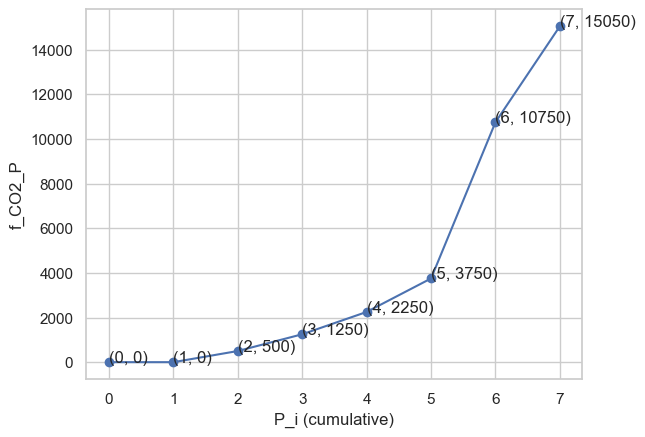

In [ ]:
X = [sum(power_sources['Capacity'][:i+1]) for i in range(len(power_sources['Capacity']))][:-1]
Y = [0, 0, 500, 1250, 2250, 3750, 10750, 15050, 648015050][:-1]
X = [i for i in range(len(Y))]
plt.plot(X,Y, marker = 'o', )
plt.ylabel('f_CO2_P')
plt.xlabel('P_i (cumulative)')
for i_x, i_y in zip(X, Y):
    plt.text(i_x, i_y, '({}, {})'.format(i_x, i_y))
print(X)
plt.show()

## Centralized with data

In [ ]:
nb_players = 3650
arr_times = scenarios_arr_times
dep_times = scenarios_dep_times
max_charging_capacity = [7 for _ in range(nb_players)]
power_needed = scenarios_energy_needed
unit_opti = 'Marginal cost'
unit_order = 'Marginal cost'
power_sources = pd.DataFrame({'Source' :['dummy','fuel','coal','gas ','nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,0,0 ,0 ,0], 'Capacity': [0,2000000,15000, 29000, 8000, 2000, 800, 100, 100 ]})
# power_sources = power_sources_data_summer
l_NF = L_NF_summer

print(l_NF, 'NON FLEXIBLE LOAD')



res_central = solve_P_centralized(nb_players = nb_players, power_needed = power_needed , max_charging_capacity = max_charging_capacity, arr_times=arr_times, dep_times= dep_times, l_NF = l_NF , power_sources = power_sources, unit_opti = unit_opti, unit_order = unit_order, f_CO2=f_CO2)
#this is to convert from the dict form to the list one 


[43747.40486111111, 43747.40486111111, 40475.316666666666, 40475.316666666666, 39090.3, 39090.3, 36750.03333333333, 36750.03333333333, 35125.333333333336, 35125.333333333336, 34936.5, 34936.5, 35988.5, 35988.5, 39076.45, 39076.45, 42567.23333333334, 42567.23333333334, 45384.933333333334, 45384.933333333334, 47247.65, 47247.65, 48398.066666666666, 48398.066666666666, 49900.71666666667, 49900.71666666667, 50692.6, 50692.6, 48931.6, 48931.6, 47656.333333333336, 47656.333333333336, 46421.28333333333, 46421.28333333333, 45302.316666666666, 45302.316666666666, 45272.58333333333, 45272.58333333333, 46555.25, 46555.25, 45749.933333333334, 45749.933333333334, 43278.3, 43278.3, 42879.71666666667, 42879.71666666667, 46833.333333333336, 46833.333333333336] NON FLEXIBLE LOAD
[[2592276.818055555, 2592276.818055555, 2592276.818055555, 2592276.818055555, 2592276.818055555, 2592276.818055555, 2592276.818055555, 3560000, 651560000], [2592276.818055555, 2592276.818055555, 2592276.818055555, 2592276.81805

C:\Users\thoma\AppData\Local\Temp\ipykernel_12872\4146450594.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_loads=np.sum(np.array(res_central[i]) for i in range(nb_players))


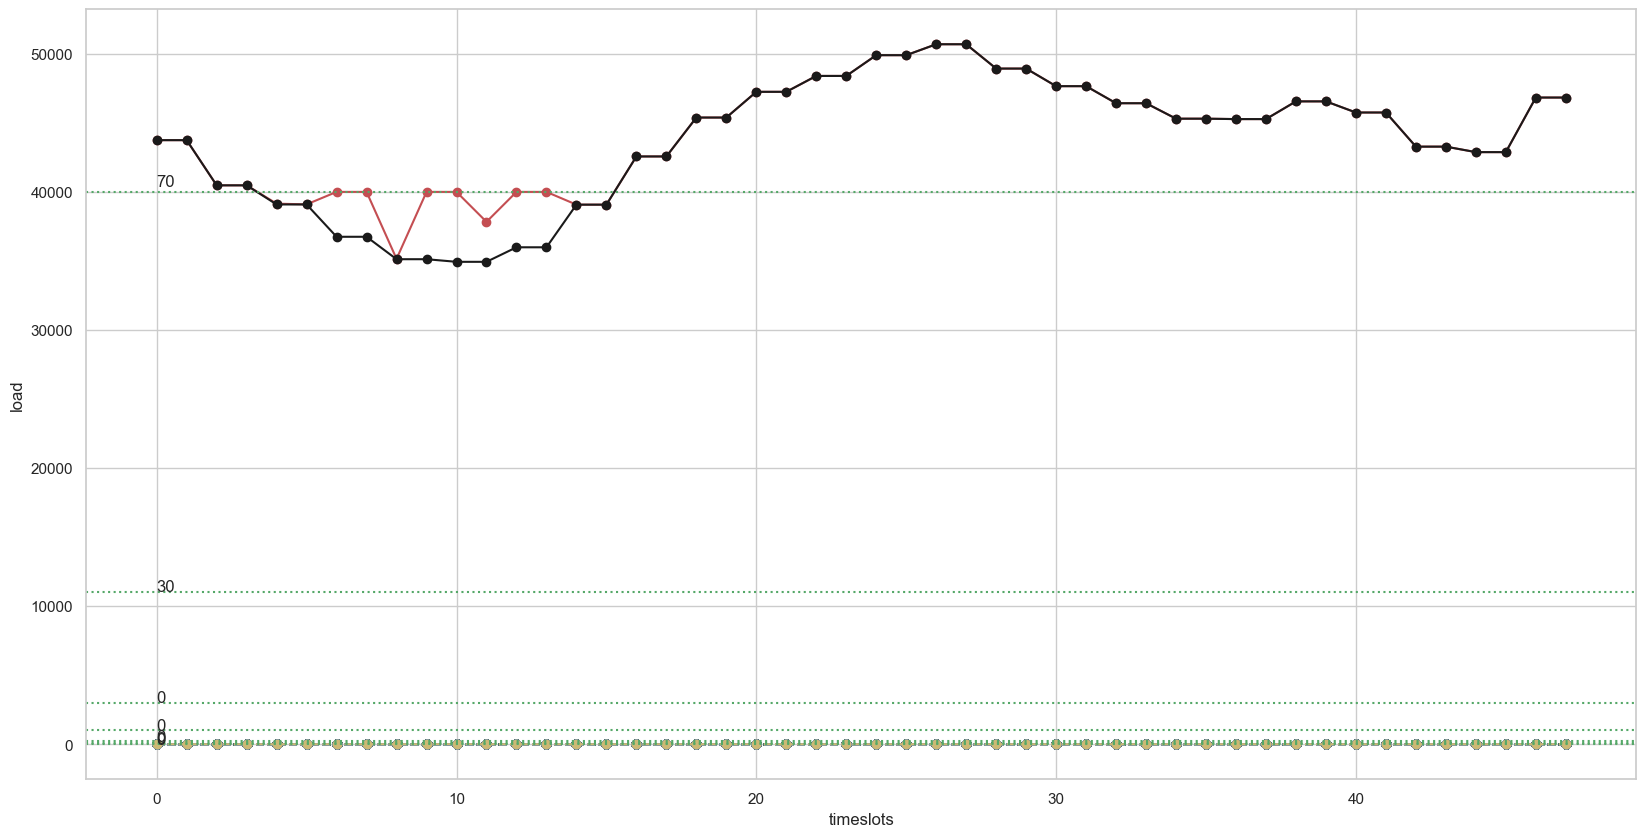

In [ ]:
#some visualization

sum_loads=np.sum(np.array(res_central[i]) for i in range(nb_players))
sum_loads = sum_loads + np.array(l_NF)
color_bank=[ 'g', 'b','c','m','y']
X = [i for i in range(48)]

fig = plt.figure()

fig.set_figwidth(20)
fig.set_figheight(10)

plt.plot(X, sum_loads, label='total load', marker='o', color='r', linestyle='-')
plt.plot(X, l_NF,label = 'non flexible', marker='o', color='k', linestyle='-')
for i in range(len(res_central)):
    plt.plot(X,res_central[i], label = 'Player ' +str(i), marker='o', color=color_bank[i % len(color_bank)], linestyle='--')
plt.xlabel('timeslots')
plt.ylabel('load')
#plt.legend()
power_sources = power_sources.sort_values([unit, 'Capacity']).reset_index(drop = True)
temp = power_sources['Capacity'].copy()
for i in range(len(temp)): #we want the cumulative capacity
        temp[i] = sum(power_sources['Capacity'][:i+1])
for i in range(len(temp[:-2])):
    plt.axhline(temp[i], linestyle=':', color ='g')
    plt.text(0, temp[i] * 1.01, str(power_sources['Marginal cost'][i]))

#plt.ylim(0,1300)
plt.show()



# Water- filling approach


In [153]:
def solve_P_j_waterfilling (L_NF, power_needed_j, max_charging_capacity, arr_time, dep_time):
    # we assume that L_NF is a numpy array of 48 elements, the non flexible load of the player and that it also contains the load of the other players!!!!
    # and power_sources are already sorted by increasing order of the unit to optimize.
    #we also assume that the cut in time slots is made at 12:00, so that time slot 0 is 12:00-12:30, time slot 1 is 12:30-13:00, etc.
    filling_timeslots = np.where(L_NF[arr_time+1:dep_time] == L_NF[arr_time+1:dep_time].min())[0] + arr_time + 1
    # print(filling_timeslots, type(filling_timeslots),'filling timeslots')
    already_used = filling_timeslots.copy()
    l_c = np.zeros(48)
    prev_ceiling = np.min(L_NF[arr_time+1:dep_time])
    k = 0
    while True:
        if k>100:
           print('max iteration reached in waterfilling')
           return None
        k+=1

        try:
            case_1 = np.min(np.delete(L_NF[arr_time+1:dep_time], already_used- arr_time-1)) - prev_ceiling
        except ValueError as e: #sometimes the filling timeslot take all the space because L_NF is nearly flat, so we artificially set a high value for case_1 such that anyway it s not chosen 
            case_1 = power_needed_j 

        if len(filling_timeslots) == 0:
            next_ceiling = case_1
        else:
            case_2 = (power_needed_j - np.sum(l_c))/len(filling_timeslots)
            case_3 = np.min((max_charging_capacity - l_c)[filling_timeslots])
            next_ceiling = np.min([case_1, case_2, case_3])
        
        
        
        if next_ceiling == case_1:#case 1, new time slot to be added
            l_c[filling_timeslots] += case_1
            to_be_added = np.where(L_NF[arr_time+1:dep_time] == np.min(np.delete(L_NF[arr_time+1:dep_time], already_used - arr_time-1)))[0] + arr_time + 1
            filling_timeslots = np.append(filling_timeslots, to_be_added)
            already_used = np.append(already_used, to_be_added)
            prev_ceiling += next_ceiling
            continue

        elif next_ceiling == case_2:#case 2 demand satisfied
            l_c[filling_timeslots] += case_2
            return l_c
        
        elif next_ceiling == case_3:# case 3 max capacity reached
            l_c[filling_timeslots] += case_3
            filling_timeslots = np.delete(filling_timeslots, np.where((max_charging_capacity - l_c)[filling_timeslots] == np.min((max_charging_capacity - l_c)[filling_timeslots]))[0])
            prev_ceiling += next_ceiling
            continue

 
    
    

[80. 73. 68. 66. 50. 31. 21. 19. 14. 12.  0.] l_c
[87.18181818 80.18181818 75.18181818 73.18181818 57.18181818 38.18181818
 28.18181818 26.18181818 21.18181818 19.18181818  7.18181818] l_c 2


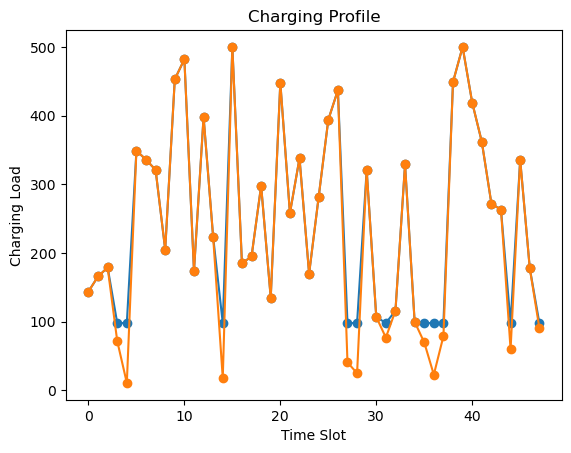

In [ ]:

# Define the inputs for testing
L_NF = np.array([rd.randint(0,500) for _ in range(48)])
power_needed_j = 513
max_charging_capacity = 400
arr_time = 0
dep_time = 48

# Call the function to get the charging profile
charging_profile = solve_P_j_waterfilling(L_NF, power_needed_j, max_charging_capacity, arr_time, dep_time)

# Plot the charging profile
time_slots = np.arange(0,48)
plt.plot(time_slots, charging_profile + L_NF, marker='o')
plt.plot(time_slots, L_NF, marker='o')
plt.xlabel('Time Slot')
plt.ylabel('Charging Load')
plt.title('Charging Profile')
plt.show()


In [ ]:

print(power_needed_j, 'power needed')
print(np.sum(charging_profile))

513 power needed
513.0


In [154]:
def BRD_charging_waterfill (eps, K, nb_players, power_needed , arr_times, dep_times ,  max_charging_capacities, l_NF, power_sources = pd.DataFrame({'Source' :['dummy','fuel','coal','gas ','nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,0,0 ,0 ,0], 'Capacity': [0,200,15, 20, 4, 1, 1, 1, 1 ]}),  unit_opti = 'Marginal cost'):
    
    
    l = np.array([[0 for _ in range(48)] for i in range(nb_players)], dtype= float)
    k=0
    prev_cost = 0

    # #moving the 'barrier at midnight' to midday. 
    # arr_times = arr_times - 24
    # dep_times = dep_times + 24
    # print(np.sum(l, axis=0), 'sum of l')
    while (np.abs(sum(f_CO2(np.sum(l, axis=0)[t] + l_NF[t], power_sources=power_sources, unit=unit_opti) for t in range(48)) - prev_cost)>= eps): #the criterion for convergence are either that the load distribution is constant, either that the CO2 emitted is constant
        if k>K:
            print(f'max iteration K={K} reached')
            break
        k+=1
        prev_cost = sum(f_CO2(np.sum(l, axis=0)[t] + l_NF[t], power_sources=power_sources, unit=unit_opti) for t in range(48)) #to check the convergence, possible to optimize
        print(f'iteration {k}/{K}')
        for player in range(nb_players):
            # print(f'iteration {k}/{K}, player {player}/{nb_players}', end='\r')
            l[player] = solve_P_j_waterfilling(L_NF = np.sum(l, axis=0)+ l_NF - l[player], power_needed_j = power_needed[player], max_charging_capacity = max_charging_capacities[player], arr_time = arr_times[player], dep_time = dep_times[player])
            

        
        
    # moving back the 'barrier at midnight' to midnight
    # print(l)
    # res = np.empty_like(l)*
    # res[:, :24] = l[:, 24:]
    # res[:, 24:] = l[:, :24]
    # print(res)
    return l

300.0 sum of l
300 power needed
300.0 sum of l
300 power needed
300.0 sum of l
300 power needed
300.0 sum of l
300 power needed
300.0 sum of l
300 power needed
300.0 sum of l
300 power needed
300.00000000000006 sum of l
300 power needed
300.0 sum of l
300 power needed
300.0 sum of l
300 power needed
300.0 sum of l
300 power needed
300.0 sum of l
300 power needed
300.0 sum of l
300 power needed
300.0 sum of l
300 power needed
300.0 sum of l
300 power needed
300.0 sum of l
300 power needed
300.0 sum of l
300 power needed
300.0 sum of l
300 power needed
300.0 sum of l
300 power needed
300.0 sum of l
300 power needed
300.0 sum of l
300 power needed


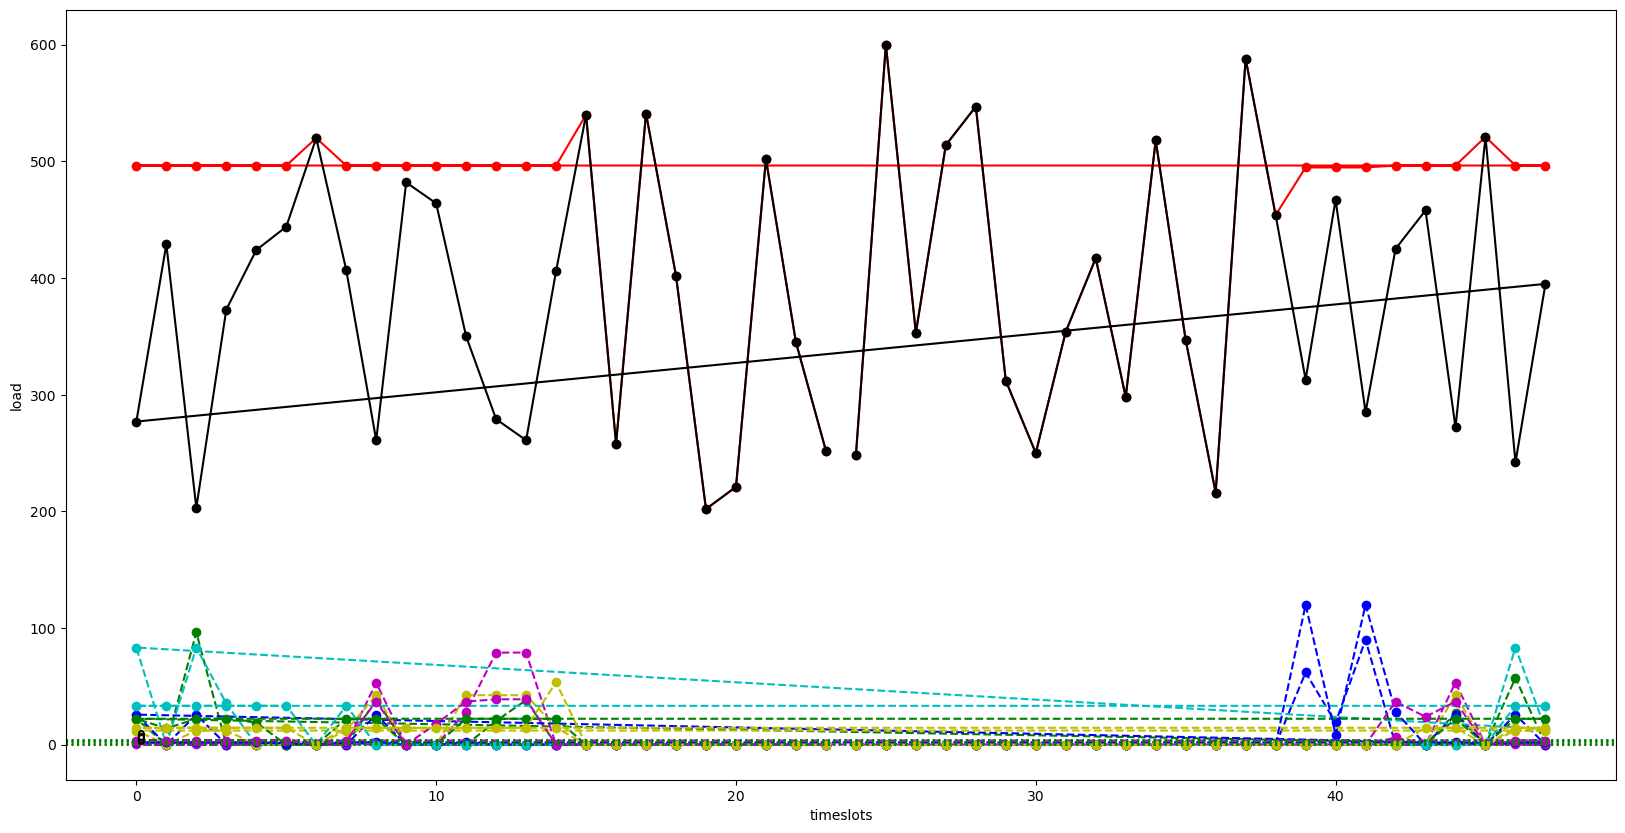

In [ ]:
# Define the inputs for testing
eps = 1
K = 100
nb_players = 10
# power_needed = np.array([400, 200, 150, 180, 120] + [340, 200, 290, 300, 120]) 
power_needed = np.array([300 for _ in range(nb_players)])
dep_times = np.array([39, 36, 32, 38, 40] + [39, 36, 32, 38, 40])
arr_times = np.array([18, 14, 20, 17, 18] + [18, 14, 20, 17, 18])
max_charging_capacities = np.array([150, 250, 200, 220, 180] + [150, 250, 200, 220, 180])
l_NF = np.array([rd.randint(200,600) for _ in range(48)])
power_sources = pd.DataFrame({'Source' :['dummy','fuel','coal','gas ','nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,0,0 ,0 ,0], 'Capacity': [0,200,15, 20, 4, 1, 1, 1, 1 ]})
#l_NF = np.array([15*i for i in range(48)])

# Call the function to get the charging profiles

res = BRD_charging_waterfill(eps, K, nb_players, power_needed, arr_times, dep_times, max_charging_capacities, l_NF, power_sources)


sum_loads=np.sum(res, axis= 0) + l_NF
color_bank=[ 'g', 'b','c','m','y']
X = [(24+i)%48 for i in range(48)]

fig = plt.figure()

fig.set_figwidth(20)
fig.set_figheight(10)

plt.plot(X, sum_loads, label='total load', marker='o', color='r', linestyle='-')
plt.plot(X, l_NF,label = 'non flexible', marker='o', color='k', linestyle='-')
for i in range(len(res)):
    plt.plot(X,res[i], label = 'Player ' +str(i), marker='o', color=color_bank[i % len(color_bank)], linestyle='--')
plt.xlabel('timeslots')
plt.ylabel('load')
#plt.legend()
power_sources = power_sources.sort_values(['Marginal cost', 'Capacity']).reset_index(drop = True)
temp = power_sources['Capacity'].copy()
for i in range(len(temp)): #we want the cumulative capacity
        temp[i] = sum(power_sources['Capacity'][:i+1])
for i in range(len(temp[:-4])):
    plt.axhline(temp[i], linestyle=':', color ='g')
    plt.text(0, temp[i] * 1.01, str(power_sources['Marginal cost'][i]))

#plt.ylim(0,1300)

plt.show()


In [ ]:
for i in range(10):
    print(power_needed[i], 'power needed')
    print(np.sum(res, axis = 1)[i], 'sum of charging profile')

300 power needed
300 sum of charging profile
300 power needed
298 sum of charging profile
300 power needed
294 sum of charging profile
300 power needed
292 sum of charging profile
300 power needed
298 sum of charging profile
300 power needed
290 sum of charging profile
300 power needed
300 sum of charging profile
300 power needed
293 sum of charging profile
300 power needed
299 sum of charging profile
300 power needed
288 sum of charging profile


# Plug and charge


In [155]:
def plug_and_charge (nb_players, max_charging_capacities, power_needed, arr_times, dep_times):
    l_c = np.array([[0 for k in range(48)] for _ in range(nb_players)])
    for player in range(nb_players):                
        try:
            temp = [max_charging_capacities[player] for _ in range( int(power_needed[player]//max_charging_capacities[player]))] + [power_needed[player]%max_charging_capacities[player]] #we fill the time slots with the max capacity, and then we add the remaining load
            l_c[player][arr_times[player]+1:dep_times[player]] = temp + [0 for _ in range(dep_times[player] - arr_times[player] - len(temp) -1)]
        except:
            print(temp, 'temp')
            print(power_needed[player], 'power_needed[player]')
            print(max_charging_capacities[player], 'max_charging_capacities[player]')
            print(arr_times[player], 'arr_times[player]')
            print(dep_times[player], 'dep_times[player]')
            print(l_c[player][arr_times[player]+1:dep_times[player]], 'l_c[player][arr_times[player]+1:dep_times[player]]')
    return l_c


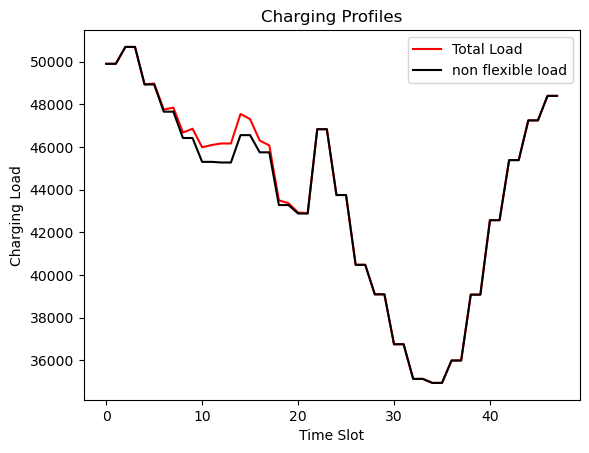

In [ ]:
# Define the inputs for testing
nb_player = 1000
unit_opti = 'Marginal cost'
unit_order = 'Marginal cost'
max_charging_capacity = [7 for _ in range(nb_player)]
power_needed = np.concatenate([scenarios_energy_needed  for _ in range(nb_player//len(scenarios_energy_needed ) + 2)])
power_needed = power_needed[:nb_player]
power_sources = pd.DataFrame({'Source' :['dummy','fuel','coal','gas ','nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,0,0 ,0 ,0], 'Capacity': [0,2000000,6000, 29000, 8000, 2000, 800, 100, 100 ]})
l_NF = L_NF_summer
arr_times = np.concatenate([scenarios_arr_times  for _ in range(nb_player//len(scenarios_arr_times ) + 2)])
arr_times = arr_times[:nb_player]
dep_times = np.concatenate([scenarios_dep_times  for _ in range(nb_player//len(scenarios_dep_times ) + 2)])
dep_times = dep_times[:nb_player]

arr_times = arr_times - 24
dep_times = dep_times + 24
temp  = [0 for _ in range(48)]
temp[24:] = l_NF[:24]
temp[:24] = l_NF[24:]
l_NF = temp

# Call the function to get the charging profiles
charging_profiles = plug_and_charge(nb_player, max_charging_capacity, power_needed, arr_times, dep_times)
# Plot the charging profiles
time_slots = list(range(48))
colors = ['r', 'g', 'b', 'c', 'm']
fig, ax = plt.subplots()
ax.plot(time_slots, np.sum(charging_profiles, axis=0) + l_NF, label='Total Load', color='r')
ax.plot(time_slots, l_NF, label='non flexible load', color='k')
ax.set_xlabel('Time Slot')
ax.set_ylabel('Charging Load')
ax.set_title('Charging Profiles')
ax.legend()
plt.show()


# Comparison plug and charge and our algorithms.

In [ ]:
power_sources_data_summer.at[4, 'Capacity'] = 0.6*power_sources_data_summer.at[4, 'Capacity']
power_sources_data_summer

,Source,CO2 emissions,Marginal cost,Capacity
0,dummy,0,0,0.0
1,fuel,777,162,452000.0
2,coal,986,86,14250.0
3,gas,429,70,2318250.0
4,nuclear,0,30,12058650.0
5,wind,0,0,5795500.0
6,solar,0,0,3624000.0
7,hydro,0,0,1313000.0
8,bioen,494,0,599750.0


In [ ]:
import matplotlib.pyplot as plt

# Define the data for the subgraphs
nb_player = 300


unit_opti = 'CO2 emissions'
unit_order = 'CO2 emissions'
max_charging_capacity = [7*10*1000 for _ in range(nb_player)]
list_nb_time_slots = np.concatenate([scenarios_time_slots  for _ in range(nb_player//len(scenarios_time_slots ) + 2)])
power_needed = np.concatenate([scenarios_energy_needed  for _ in range(nb_player//len(scenarios_energy_needed ) + 2)]) * 10*1000
power_needed = power_needed[:nb_player]
#power_sources = pd.DataFrame({'Source' :['dummy','fuel','coal','gas ','nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,0,0 ,0 ,0], 'Capacity': [0,2000000,6000, 29000, 8000, 2000, 800, 100, 100 ]})
#power_sources = power_sources_germany_cap
power_sources = power_sources_data_summer
power_sources = power_sources.sort_values([unit_order, 'Capacity']).reset_index(drop=True)
l_NF = L_NF_summer
#print(l_NF, 'NON FLEXIBLE LOAD')
l_0  = [[0 for _ in range(48)] for i in range(nb_player)]
arr_times = np.concatenate([scenarios_arr_times  for _ in range(nb_player//len(scenarios_arr_times ) + 2)])
arr_times = arr_times[:nb_player]
dep_times = np.concatenate([scenarios_dep_times  for _ in range(nb_player//len(scenarios_dep_times ) + 2)])
dep_times = dep_times[:nb_player]
eps = 10
K= 1000

#adapt it to the switch of the barrier at midnight:
arr_times_waterfill = arr_times - 24
dep_times_waterfill = dep_times + 24
l_NF_waterfill = [0 for _ in range(48)]
l_NF_waterfill[24:] = l_NF[:24]
l_NF_waterfill[:24] = l_NF[24:]



x = [i for i in range(48)]  # x-axis values
x_from_12 = [(24+i)%48 for i in range(48)]
y_solve_P_centralized = solve_P_centralized(nb_players = nb_player, power_needed = power_needed , max_charging_capacity = max_charging_capacity, arr_times=arr_times, dep_times= dep_times, l_NF = l_NF , power_sources = power_sources, unit_opti = unit_opti, unit_order = unit_order, f_CO2=f_CO2)  # y-axis values for solve_P_centralized
y_BRD_waterfill = BRD_charging_waterfill(eps, K, nb_player, power_needed, arr_times_waterfill, dep_times_waterfill, max_charging_capacity, l_NF_waterfill, power_sources)  # y-axis values for BRD_waterfill
y_plug_and_charge = plug_and_charge(nb_player, max_charging_capacity, power_needed, arr_times_waterfill, dep_times_waterfill)  # y-axis values for plug_and_charge
y_BRD = BRD_charging(l_0=l_0, eps=eps, K=K, arr_times= arr_times, list_nb_time_slots= list_nb_time_slots ,l_NF= l_NF, power_needed=power_needed, max_charging_capacity= max_charging_capacity[0] ,power_sources= power_sources, unit_opti=unit_opti, unit_order = unit_order)  # y-axis values for BRD



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\thoma\AppData\Local\Temp\tmpa4rnulvj.glpk.raw --wglp C:\Users\thoma\AppData\Local\Temp\tmpr3r57vtu.glpk.glp
 --cpxlp C:\Users\thoma\AppData\Local\Temp\tmpb4f1pcdy.pyomo.lp
Reading problem data from 'C:\Users\thoma\AppData\Local\Temp\tmpb4f1pcdy.pyomo.lp'...
C:\Users\thoma\AppData\Local\Temp\tmpb4f1pcdy.pyomo.lp:104836: warning: lower bound of variable 'x518' redefined
C:\Users\thoma\AppData\Local\Temp\tmpb4f1pcdy.pyomo.lp:104836: warning: upper bound of variable 'x518' redefined
15061 rows, 14882 columns, 44550 non-zeros
217 integer variables, all of which are binary
105053 lines were read
Writing problem data to 'C:\Users\thoma\AppData\Local\Temp\tmpr3r57vtu.glpk.glp'...
97175 lines were written
GLPK Integer Optimizer 5.0
15061 rows, 14882 columns, 44550 non-zeros
217 integer variables, all of which are binary
Preprocessing...
582 rows, 7556 columns, 15423 non-zeros
155 integer variables, all 

9481125116.666668 f_C02_cent
9481125116.666668 f_C02_BRD_waterfill
18288760683.33333 f_C02_plug_and_charge
9481125116.666668 f_C02_BRD
0.0 f_C02_flex_cent
0.0 f_C02_flex_BRD_waterfill
8807635566.66666 f_C02_flex_plug_and_charge
0.0 f_C02_flex_BRD


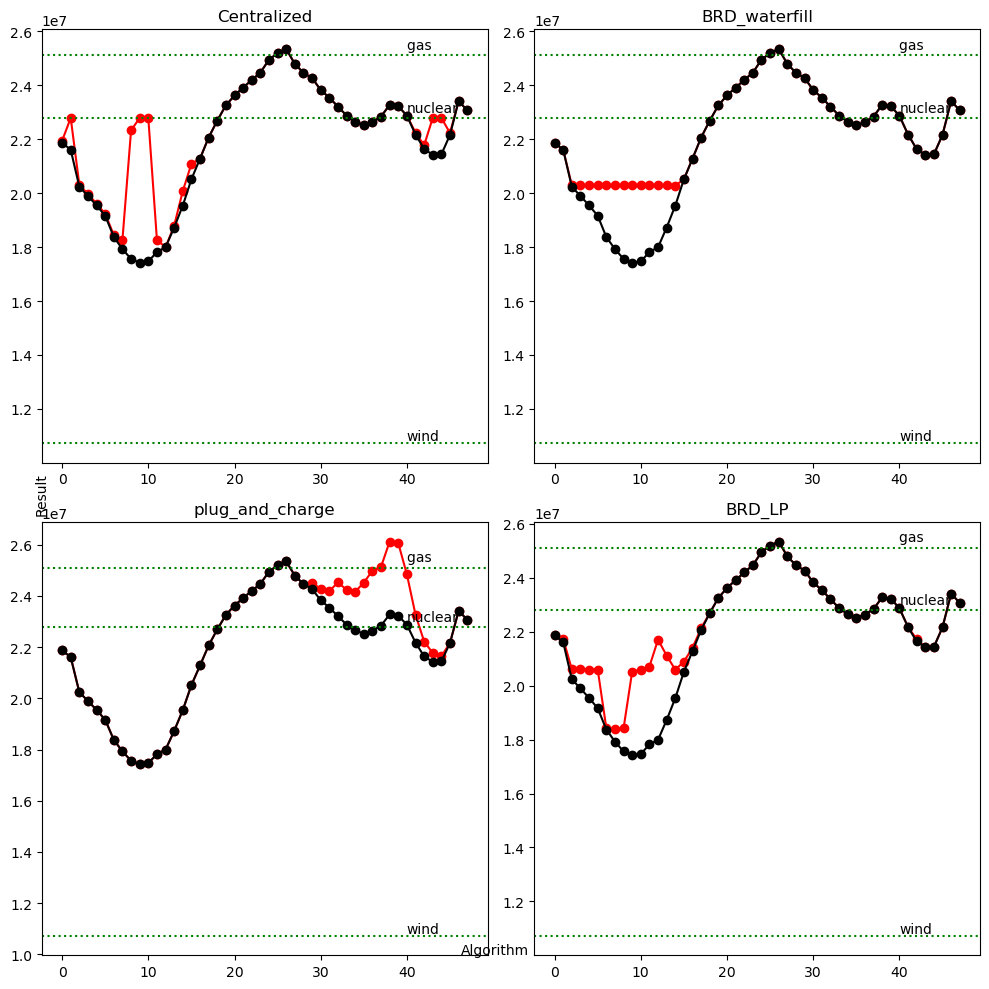

In [ ]:
# Create the subplots
# power_sources= power_sources_germany_cap
power_sources = power_sources.sort_values([unit_order, 'Capacity']).reset_index(drop=True)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

y_BRD_waterfill_temp = np.empty_like(y_BRD_waterfill)
y_BRD_waterfill_temp[:, :24] = y_BRD_waterfill[:, 24:].copy()  # moving back the 'barrier at midnight' to midnight
y_BRD_waterfill_temp[:, 24:] = y_BRD_waterfill[:, :24].copy()  # moving back the 'barrier at midnight' to midnight

y_plug_and_charge_temp = np.empty_like(y_plug_and_charge)
y_plug_and_charge_temp[:, :24] = y_plug_and_charge[:, 24:].copy()  # moving back the 'barrier at midnight' to midnight
y_plug_and_charge_temp[:, 24:] = y_plug_and_charge[:, :24].copy()  # moving back the 'barrier at midnight' to midnight

# Plot the data for solve_P_centralized
axs[0, 0].plot(x, np.sum(y_solve_P_centralized, axis = 0) +l_NF, marker='o', label='total load centralized', color='r')
axs[0, 0].plot(x, l_NF, marker='o', color='k', label='non flexible load')
axs[0, 0].set_title(f'Centralized')

# Plot the data for BRD_waterfill
axs[0,1].plot(x, np.sum(y_BRD_waterfill_temp, axis = 0) +l_NF, marker='o', label='total load BRD_waterfill', color='r')
axs[0,1].plot(x, l_NF, marker='o', color='k', label='non flexible load')
axs[0, 1].set_title(f'BRD_waterfill')

# Plot the data for plug_and_charge
axs[1,0].plot(x, np.sum(y_plug_and_charge_temp, axis = 0) +l_NF, marker='o', label='total load plug and charge', color='r')
axs[1,0].plot(x, l_NF, marker='o', color='k', label='non flexible load')
axs[1, 0].set_title(f'plug_and_charge')

# Plot the data for BRD
axs[1, 1].plot(x, np.sum(y_BRD, axis = 0) +l_NF, marker='o', label='total load BRD', color='r')
axs[1, 1].plot(x, l_NF, marker='o', color='k', label='non flexible load')
axs[1, 1].set_title(f'BRD_LP')

power_sources = power_sources.sort_values([unit_order, 'Capacity']).reset_index(drop=True)
temp = power_sources['Capacity'].copy()
for k in range(len(temp)): #we want the cumulative capacity
    temp[k] = sum(power_sources['Capacity'][:k+1])
for k in range(len(temp[3:-3])):
    for a in range(2):
        for b in range(2):
            axs[a, b].axhline(temp[3+k], linestyle=':', color ='g')
            axs[a, b].text(40, temp[3+k] * 1.01, str(power_sources['Source'][3+k]))
# Set the common x-axis label
fig.text(0.5, 0.04, 'Algorithm', ha='center')

# Set the common y-axis label
fig.text(0.04, 0.5, 'Result', va='center', rotation='vertical')

# Adjust the spacing between subplots
fig.tight_layout()

f_C02_cent =sum(f_CO2(np.sum(y_solve_P_centralized, axis = 0)[t] + l_NF[t], power_sources=power_sources, unit=unit_opti) for t in range(48))
f_C02_BRD_waterfill = sum(f_CO2(np.sum(y_BRD_waterfill_temp, axis = 0)[t] + l_NF[t], power_sources=power_sources, unit=unit_opti) for t in range(48))
f_C02_plug_and_charge = sum(f_CO2(np.sum(y_plug_and_charge_temp, axis = 0)[t] + l_NF[t], power_sources=power_sources, unit=unit_opti) for t in range(48))
f_C02_BRD = sum(f_CO2(np.sum(y_BRD, axis = 0)[t] + l_NF[t], power_sources=power_sources, unit=unit_opti) for t in range(48))

f_C02_flex_cent = f_C02_cent - sum(f_CO2(l_NF[t], power_sources=power_sources, unit=unit_opti) for t in range(48))
f_C02_flex_BRD_waterfill = f_C02_BRD_waterfill - sum(f_CO2(l_NF[t], power_sources=power_sources, unit=unit_opti) for t in range(48))
f_C02_flex_plug_and_charge = f_C02_plug_and_charge - sum(f_CO2(l_NF[t], power_sources=power_sources, unit=unit_opti) for t in range(48))
f_C02_flex_BRD = f_C02_BRD - sum(f_CO2(l_NF[t], power_sources=power_sources, unit=unit_opti) for t in range(48))


print(f_C02_cent, 'f_C02_cent')
print(f_C02_BRD_waterfill, 'f_C02_BRD_waterfill')
print(f_C02_plug_and_charge, 'f_C02_plug_and_charge')
print(f_C02_BRD, 'f_C02_BRD')

print(f_C02_flex_cent, 'f_C02_flex_cent')
print(f_C02_flex_BRD_waterfill, 'f_C02_flex_BRD_waterfill')
print(f_C02_flex_plug_and_charge, 'f_C02_flex_plug_and_charge')
print(f_C02_flex_BRD, 'f_C02_flex_BRD')
# Show the subgraphs
plt.show()

In [ ]:
print(power_sources, 'power_sources')

    Source  CO2 emissions  Marginal cost    Capacity
0    dummy              0              0         0.0
1    hydro              0              0   1313000.0
2    solar              0              0   3624000.0
3     wind              0              0   5795500.0
4  nuclear              0             30  20097750.0
5     gas             429             70   2318250.0
6    bioen            494              0    599750.0
7     fuel            777            162    452000.0
8     coal            986             86     14250.0 power_sources


9481125116.666668 f_C02_cent
9481125116.666668 f_C02_BRD_waterfill
18288760683.33333 f_C02_plug_and_charge
9481125116.666668 f_C02_BRD
0.0 f_C02_flex_cent
0.0 f_C02_flex_BRD_waterfill
8807635566.66666 f_C02_flex_plug_and_charge
0.0 f_C02_flex_BRD


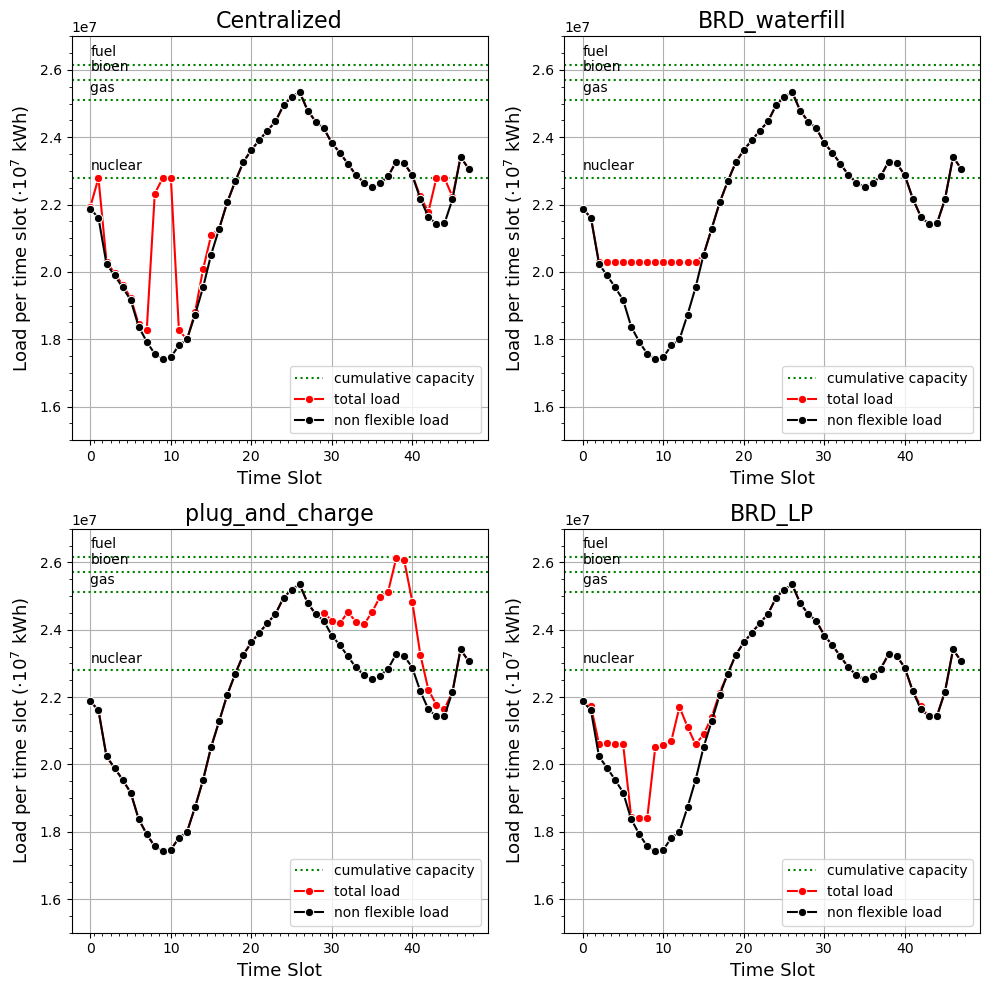

In [ ]:
import seaborn as sns
# Create the subplots



# power_sources= power_sources_germany_cap
power_sources = power_sources.sort_values([unit_order, 'Capacity']).reset_index(drop=True)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

y_BRD_waterfill_temp = np.empty_like(y_BRD_waterfill)
y_BRD_waterfill_temp[:, :24] = y_BRD_waterfill[:, 24:].copy()  # moving back the 'barrier at midnight' to midnight
y_BRD_waterfill_temp[:, 24:] = y_BRD_waterfill[:, :24].copy()  # moving back the 'barrier at midnight' to midnight

y_plug_and_charge_temp = np.empty_like(y_plug_and_charge)
y_plug_and_charge_temp[:, :24] = y_plug_and_charge[:, 24:].copy()  # moving back the 'barrier at midnight' to midnight
y_plug_and_charge_temp[:, 24:] = y_plug_and_charge[:, :24].copy()  # moving back the 'barrier at midnight' to midnight

power_sources = power_sources.sort_values([unit_order, 'Capacity']).reset_index(drop=True)
temp = power_sources['Capacity'].copy()
for k in range(len(temp)):  # we want the cumulative capacity
    temp[k] = sum(power_sources['Capacity'][:k + 1])
switch = 0
for k in range(len(temp[4:-1])):
    switch += 1
    for a in range(2):
        for b in range(2):
            if switch == 1:
                axs[a, b].axhline(temp[4 + k], linestyle=':', color='g', label='cumulative capacity')
                axs[a, b].text(0, temp[4 + k] * 1.01, str(power_sources['Source'][4 + k]), fontsize=10)
            elif str(power_sources['Source'][1 + k]) == 'bioen':
                axs[a, b].axhline(temp[4 + k], linestyle=':', color='g')
                axs[a, b].text(5, temp[4 + k] * 1.01, str(power_sources['Source'][4 + k]), fontsize=10)
                
            else:
                axs[a, b].axhline(temp[4 + k], linestyle=':', color='g')
                axs[a, b].text(0, temp[4 + k] * 1.01, str(power_sources['Source'][4 + k]), fontsize=10)
            

# Plot the data for solve_P_centralized
sns.lineplot(x=x, y=np.sum(y_solve_P_centralized, axis=0) + l_NF, marker='o', label='total load', color='r', ax=axs[0, 0])
sns.lineplot(x=x, y=l_NF, marker='o', color='k', label='non flexible load', ax=axs[0, 0])
axs[0, 0].set_title(f'Centralized', fontsize=16)
axs[0, 0].legend(loc='lower right')  # Set the legend location to lower left
axs[0, 0].set_xlabel('Time Slot', fontsize = 13)
axs[0, 0].set_ylabel(r'Load per time slot ($\cdot 10^7$ kWh)', fontsize = 13)
axs[0, 0].set_xticks(np.arange(0.5, 48, 1), minor=True)
axs[0, 0].set_yticks(np.arange(1.5*10**7, np.max(np.sum(y_solve_P_centralized, axis=0) + l_NF) + 0.2*10**7, 50 * 10**4), minor=True)
axs[0, 0].grid(True)  # Add grid

# Plot the data for BRD_waterfill
sns.lineplot(x=x, y=np.sum(y_BRD_waterfill_temp, axis=0) + l_NF, marker='o', label='total load', color='r', ax=axs[0, 1])
sns.lineplot(x=x, y=l_NF, marker='o', color='k', label='non flexible load', ax=axs[0, 1])
axs[0, 1].set_title(f'BRD_waterfill', fontsize=16)
axs[0, 1].legend(loc='lower right')  # Set the legend location to lower left
axs[0, 1].set_xlabel('Time Slot', fontsize = 13)
axs[0, 1].set_ylabel(r'Load per time slot ($\cdot 10^7$ kWh)', fontsize = 13)
axs[0, 1].set_xticks(np.arange(0.5, 48, 1), minor=True)
axs[0, 1].set_yticks(np.arange(1.5*10**7, np.max(np.sum(y_solve_P_centralized, axis=0) + l_NF) + 0.2*10**7, 50 * 10**4), minor=True)
axs[0, 1].grid(True)  # Add grid

# Plot the data for plug_and_charge
sns.lineplot(x=x, y=np.sum(y_plug_and_charge_temp, axis=0) + l_NF, marker='o', label='total load', color='r', ax=axs[1, 0])
sns.lineplot(x=x, y=l_NF, marker='o', color='k', label='non flexible load', ax=axs[1, 0])
axs[1, 0].set_title(f'plug_and_charge', fontsize=16)
axs[1, 0].legend(loc='lower right')  # Set the legend location to lower left
axs[1, 0].set_xlabel('Time Slot', fontsize = 13)
axs[1, 0].set_ylabel(r'Load per time slot ($\cdot 10^7$ kWh)', fontsize = 13)
axs[1, 0].set_xticks(np.arange(0.5, 48, 1), minor=True)
axs[1, 0].set_yticks(np.arange(1.5*10**7, np.max(np.sum(y_solve_P_centralized, axis=0) + l_NF) + 0.2*10**7, 50 * 10**4), minor=True)
axs[1, 0].grid(True)  # Add grid

# Plot the data for BRD
sns.lineplot(x=x, y=np.sum(y_BRD, axis=0) + l_NF, marker='o', label='total load', color='r', ax=axs[1, 1])
sns.lineplot(x=x, y=l_NF, marker='o', color='k', label='non flexible load', ax=axs[1, 1])
axs[1, 1].set_title(f'BRD_LP', fontsize=16)
axs[1, 1].legend(loc='lower right')  # Set the legend location to lower left
axs[1, 1].set_xlabel('Time Slot', fontsize = 13)
axs[1, 1].set_ylabel(r'Load per time slot ($\cdot 10^7$ kWh)', fontsize = 13)
axs[1, 1].set_xticks(np.arange(0.5, 48, 1), minor=True)
axs[1, 1].set_yticks(np.arange(1.5*10**7, np.max(np.sum(y_solve_P_centralized, axis=0) + l_NF) + 0.2*10**7, 50 * 10**4), minor=True)
axs[1, 1].grid(True)  # Add grid




# Adjust the spacing between subplots
fig.tight_layout()
#fig.suptitle('Comparison in terms of CO2 emissions, French data, 3 000 000 cars simulated', fontsize=16)

f_C02_cent = sum(f_CO2(np.sum(y_solve_P_centralized, axis=0)[t] + l_NF[t], power_sources=power_sources, unit=unit_opti) for t in range(48))
f_C02_BRD_waterfill = sum(f_CO2(np.sum(y_BRD_waterfill_temp, axis=0)[t] + l_NF[t], power_sources=power_sources, unit=unit_opti) for t in range(48))
f_C02_plug_and_charge = sum(f_CO2(np.sum(y_plug_and_charge_temp, axis=0)[t] + l_NF[t], power_sources=power_sources, unit=unit_opti) for t in range(48))
f_C02_BRD = sum(f_CO2(np.sum(y_BRD, axis=0)[t] + l_NF[t], power_sources=power_sources, unit=unit_opti) for t in range(48))

f_C02_flex_cent = f_C02_cent - sum(f_CO2(l_NF[t], power_sources=power_sources, unit=unit_opti) for t in range(48))
f_C02_flex_BRD_waterfill = f_C02_BRD_waterfill - sum(f_CO2(l_NF[t], power_sources=power_sources, unit=unit_opti) for t in range(48))
f_C02_flex_plug_and_charge = f_C02_plug_and_charge - sum(f_CO2(l_NF[t], power_sources=power_sources, unit=unit_opti) for t in range(48))
f_C02_flex_BRD = f_C02_BRD - sum(f_CO2(l_NF[t], power_sources=power_sources, unit=unit_opti) for t in range(48))

print(f_C02_cent, 'f_C02_cent')
print(f_C02_BRD_waterfill, 'f_C02_BRD_waterfill')
print(f_C02_plug_and_charge, 'f_C02_plug_and_charge')
print(f_C02_BRD, 'f_C02_BRD')

print(f_C02_flex_cent, 'f_C02_flex_cent')
print(f_C02_flex_BRD_waterfill, 'f_C02_flex_BRD_waterfill')
print(f_C02_flex_plug_and_charge, 'f_C02_flex_plug_and_charge')
print(f_C02_flex_BRD, 'f_C02_flex_BRD')

# Show the subgraphs
plt.show()

In [ ]:
print(power_sources_data_summer)

    Source  CO2 emissions  Marginal cost  Capacity
0    dummy              0              0       0.0
1     fuel            777            162     904.0
2     coal            986             86      28.5
3     gas             429             70    4636.5
4  nuclear              0             30   40195.5
5     wind              0              0   11591.0
6    solar              0              0    7248.0
7    hydro              0              0    2626.0
8    bioen            494              0    1199.5


#  Time complexity comparison, Centralized vs Decentralized

In [159]:
import timeit
import numpy as np

#nb_players = [10] + [i for i in range(100, 1000, 100)]  # Adjust the range of nb_players as needed
nb_players = [10**i for i in range(6, 7)]
nb_players = [500000]
times_f1 = []
times_f2 = []
times_f3 = []
times_f4 = []

for nb_player in nb_players:
    print(nb_player, 'nb_player \n')
    unit_opti = 'Marginal cost'
    unit_order = 'Marginal cost'
    max_charging_capacity = [7 for _ in range(nb_player)]
    nb_time_slots = 24
    power_needed = np.concatenate([scenarios_energy_needed  for _ in range(nb_player//len(scenarios_energy_needed ) + 2)])
    power_needed = power_needed[:nb_player]
    #power_sources = pd.DataFrame({'Source' :['dummy','fuel','coal','gas ','nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,0,0 ,0 ,0], 'Capacity': [0,2000000000,6000000000, 29000000, 8000000, 2000000, 80000, 100, 100 ]})
    power_sources = power_sources_data_summer
    l_NF = L_NF_summer
    #print(l_NF, 'NON FLEXIBLE LOAD')
    l_0  = [[0 for _ in range(48)] for i in range(nb_player)]
    arr_times = np.concatenate([scenarios_arr_times  for _ in range(nb_player//len(scenarios_arr_times ) + 2)])
    arr_times = arr_times[:nb_player]
    dep_times = np.concatenate([scenarios_dep_times  for _ in range(nb_player//len(scenarios_dep_times ) + 2)])
    dep_times = dep_times[:nb_player]
    list_nb_time_slots = np.concatenate([scenarios_time_slots  for _ in range(nb_player//len(scenarios_time_slots ) + 2)])
    list_nb_time_slots = list_nb_time_slots[:nb_player]
    eps = 10
    K= 1000

    #adapt it to the switch of the barrier at midnight:
    arr_times_waterfill = arr_times - 24
    dep_times_waterfill = dep_times + 24
    l_NF_waterfill = [0 for _ in range(48)]
    l_NF_waterfill[24:] = l_NF[:24]
    l_NF_waterfill[:24] = l_NF[24:]

    # time_f1 = timeit.timeit(lambda:  solve_P_centralized(nb_players = nb_player, power_needed = power_needed , max_charging_capacity = max_charging_capacity, arr_times=arr_times, dep_times= dep_times, l_NF = l_NF , power_sources = power_sources, unit_opti = unit_opti, unit_order = unit_order, f_CO2=f_CO2), number=1)
    time_f2 = timeit.timeit(lambda: BRD_charging_waterfill(eps, K, nb_player, power_needed, arr_times_waterfill, dep_times_waterfill, max_charging_capacity, l_NF_waterfill, power_sources), number=1)
    # time_f3 = timeit.timeit(lambda: plug_and_charge(nb_player, max_charging_capacity, power_needed, arr_times, dep_times), number=1)
    #time_f4 = timeit.timeit(lambda: BRD_charging(l_0=l_0, eps=eps, K=K, arr_times= arr_times, list_nb_time_slots= list_nb_time_slots ,l_NF= l_NF, power_needed=power_needed, max_charging_capacity= max_charging_capacity[0] ,power_sources= power_sources, unit_opti=unit_opti, unit_order = unit_order), number=1)

    # times_f1.append(time_f1)
    times_f2.append(time_f2)
    # times_f3.append(time_f3)
    #times_f4.append(time_f4)

np.savetxt('times_f2.txt', [times_f2, nb_players], delimiter=',', fmt='%s')
print(times_f1, 'times_f1')

# plt.plot(nb_players, times_f1, label='BRD_waterfilling')
# plt.plot(nb_players, times_f2, label='Centralized')
# plt.plot(nb_players, times_f3, label='plug_and_charge')
# plt.plot(nb_players, times_f4, label='BRD_LP')
# plt.xlabel('Number of Players')
# plt.ylabel('Execution Time (seconds)')
# plt.title('Time Complexity Analysis')
# plt.legend()

# file_name = './graphs/both_time_complexity_until_' + str(nb_players[-1]) + '.png'
# plt.savefig(file_name)
# plt.show()



500000 nb_player 

iteration 1/1000
iteration 2/1000


In [ ]:
print(times_f4)

[7.813220500014722, 70.92447849968448, 888.3895535999909]


In [ ]:
Centralized dies at 40 000
[0.7528377003036439, 0.9394344002939761, 5.382314699701965, 182.52539910003543] times_f1
[0.2413182002492249, 0.27427419973537326, 0.5374250998720527, 9.464043200016022, 609.8927428000607] times_f2
[7.813220500014722, 70.92447849968448, 888.3895535999909] times_f4

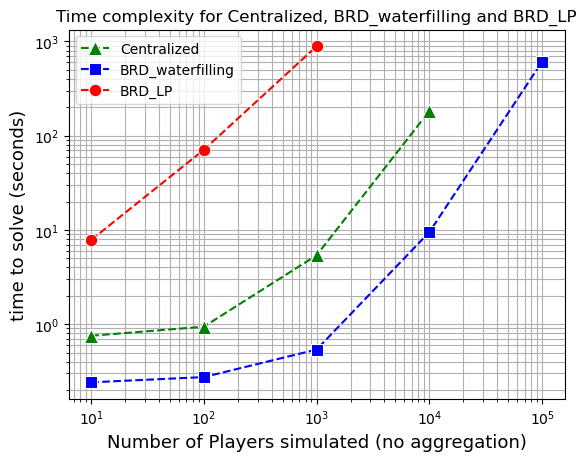

In [ ]:
# Create the plot
line1 = sns.lineplot(x=X1, y=Y1, label='Centralized', marker='^', color='g', linestyle='--', ms= 10)
line2 = sns.lineplot(x=X2, y=Y2, label='BRD_waterfilling', marker='s', color='b', linestyle='--', ms= 9)
line3 = sns.lineplot(x=X3, y=Y3, label='BRD_LP', marker='o', color='r', linestyle='--', ms= 9)

# Set the labels and title
plt.xlabel('Number of Players simulated (no aggregation)', fontsize=13)
plt.ylabel('time to solve (seconds)', fontsize=13)
plt.title('Time complexity for Centralized, BRD_waterfilling and BRD_LP')

# Set the log scale
plt.xscale('log')
plt.yscale('log')

# Add grid on major and minor ticks

plt.grid(True, which='both', linestyle='-')
# Show the legend
plt.legend()

# Show the plot
plt.show()


   nb_players    times BRD  times centralized
0           0     0.000051           0.513470
1         200   172.572545           0.581578
2         400   303.638620           0.873872
3         600   578.409540           1.453732
4         800   830.160679           1.662451
5        1000   965.185981           1.716737
6        1200  1169.518379           2.027702
7        1400  1397.511865           2.446488
8        1600  3772.050874           2.654919


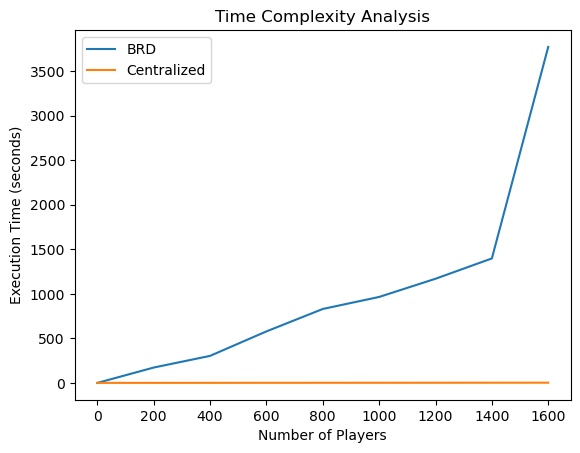

In [ ]:
import seaborn as sns
df_plot = pd.read_csv('./data/times_complexity_1')
print(df_plot)

sns.lineplot(data=df_plot, x='nb_players', y='times BRD', label='BRD')
sns.lineplot(data=df_plot, x='nb_players', y='times centralized', label='Centralized')
plt.xlabel('Number of Players')
plt.ylabel('Execution Time (seconds)')
plt.title('Time Complexity Analysis')
plt.legend()
plt.show()

# Comparison between different unit of ordering and optimization

In [ ]:
nb_players = 3650
max_charging_capacity = [7 for _ in range(nb_players)]
power_needed = scenarios_energy_needed[:nb_players]
power_sources = pd.DataFrame({'Source' :['dummy','fuel','coal','gas ','nuclear' ,'wind' ,'solar' ,'hydro' ,'bioen'], 'CO2 emissions' : [0,777 ,986 ,429 ,0 ,0,0 ,0 ,494] ,'Marginal cost': [0,162 ,86 ,70 ,30 ,0,0 ,0 ,0], 'Capacity': [0,2000000,6000, 29000, 8000, 2000, 800, 100, 100 ]})
#power_sources = power_sources_data_summer
l_NF = L_NF_summer
print(l_NF, 'NON FLEXIBLE LOAD')
l_0  = [[0 for _ in range(48)] for i in range(nb_players)]
arr_times = scenarios_arr_times[:nb_players]
dep_times = scenarios_dep_times[:nb_players]
#arr_times = [0 for _ in range(len(scenarios_arr_times))]
eps = 100
K= 100

res_dic = {}
for unit_order in ['Marginal cost', 'CO2 emissions']:
    for unit_opti in ['Marginal cost', 'CO2 emissions']:
        print('iteration:', unit_order, unit_opti)
        res_dic[(unit_order, unit_opti)] = solve_P_centralized(nb_players = nb_players, power_needed = power_needed , max_charging_capacity = max_charging_capacity, arr_times=arr_times, dep_times= dep_times, l_NF = l_NF , power_sources = power_sources, unit_opti = unit_opti, unit_order = unit_order, f_CO2=f_CO2)




[43747.40486111111, 43747.40486111111, 40475.316666666666, 40475.316666666666, 39090.3, 39090.3, 36750.03333333333, 36750.03333333333, 35125.333333333336, 35125.333333333336, 34936.5, 34936.5, 35988.5, 35988.5, 39076.45, 39076.45, 42567.23333333334, 42567.23333333334, 45384.933333333334, 45384.933333333334, 47247.65, 47247.65, 48398.066666666666, 48398.066666666666, 49900.71666666667, 49900.71666666667, 50692.6, 50692.6, 48931.6, 48931.6, 47656.333333333336, 47656.333333333336, 46421.28333333333, 46421.28333333333, 45302.316666666666, 45302.316666666666, 45272.58333333333, 45272.58333333333, 46555.25, 46555.25, 45749.933333333334, 45749.933333333334, 43278.3, 43278.3, 42879.71666666667, 42879.71666666667, 46833.333333333336, 46833.333333333336] NON FLEXIBLE LOAD
iteration: Marginal cost Marginal cost
[[2592276.818055555, 2592276.818055555, 2592276.818055555, 2592276.818055555, 2592276.818055555, 2592276.818055555, 2592276.818055555, 2786000, 650786000], [2592276.818055555, 2592276.8180

0
0


C:\Users\thoma\AppData\Local\Temp\ipykernel_12872\2136110451.py:20: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_loads=np.sum(np.array(res_dic[unit_order_val, unit_opti_val][i]) for i in range(nb_players))
C:\Users\thoma\AppData\Local\Temp\ipykernel_12872\2136110451.py:20: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_loads=np.sum(np.array(res_dic[unit_order_val, unit_opti_val][i]) for i in range(nb_players))


1
1


C:\Users\thoma\AppData\Local\Temp\ipykernel_12872\2136110451.py:20: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_loads=np.sum(np.array(res_dic[unit_order_val, unit_opti_val][i]) for i in range(nb_players))
C:\Users\thoma\AppData\Local\Temp\ipykernel_12872\2136110451.py:20: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum_loads=np.sum(np.array(res_dic[unit_order_val, unit_opti_val][i]) for i in range(nb_players))


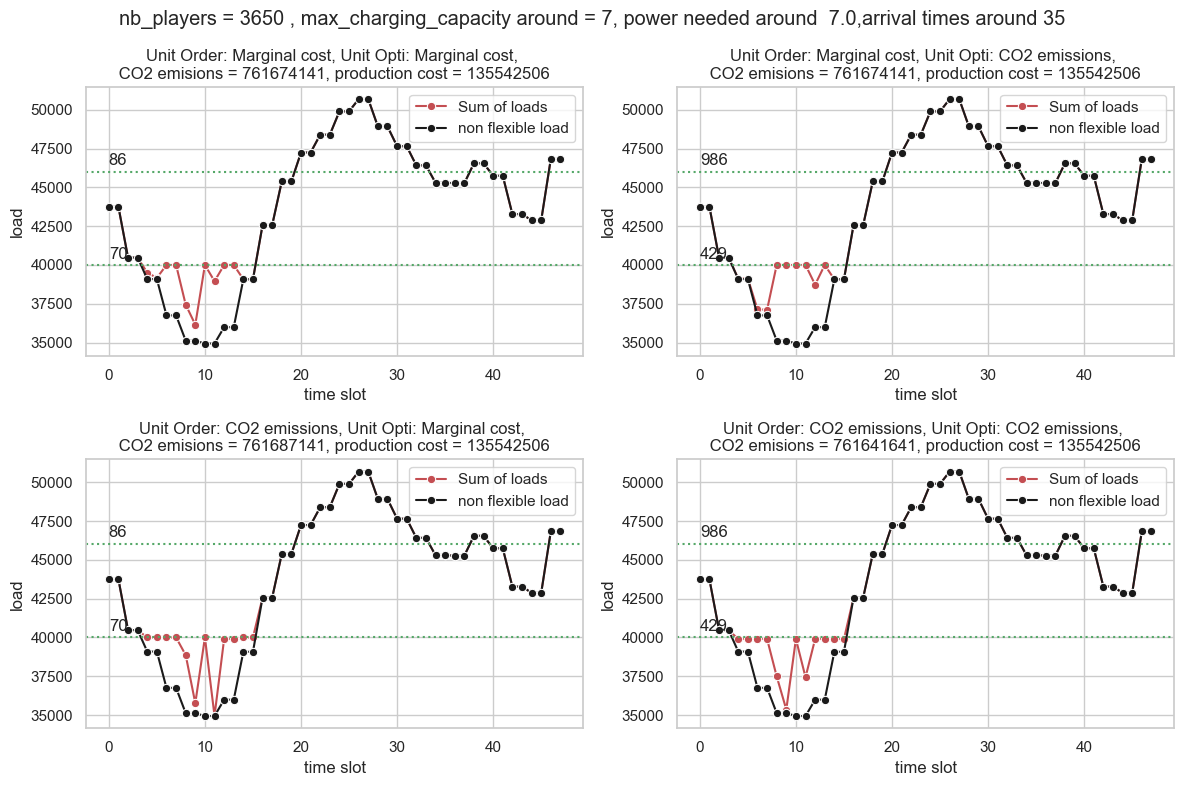

In [ ]:
import seaborn as sns
import mpl_interactions.ipyplot as iplt


unit_order = ['Marginal cost', 'CO2 emissions']
unit_opti = ['Marginal cost', 'CO2 emissions']
# Plotting
sns.set_theme()
sns.set_context("notebook")
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Reducing figure size
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle(f'nb_players = {nb_players} , max_charging_capacity around = {sum(max_charging_capacity)//len(max_charging_capacity)}, power needed around  {sum(power_needed)//len(power_needed)},arrival times around {sum(arr_times)//len(arr_times)}')

for i, unit_order_val in enumerate(unit_order):
    for j, unit_opti_val in enumerate(unit_opti):
        print(i)
        ax = axes[i, j]
        sum_loads=np.sum(np.array(res_dic[unit_order_val, unit_opti_val][i]) for i in range(nb_players))
        sum_loads = sum_loads + np.array(l_NF)
        sns.lineplot(x=[i for i in range(48)], y=sum_loads, label='Sum of loads', color='r', marker='o', ax=ax)
        sns.lineplot(x=[i for i in range(48)], y=l_NF, label='non flexible load', color='k', marker='o', ax=ax)
        temp_CO2 = 'CO2 emissions' #because one cannot put a string in a f string
        temp_prod = 'Marginal cost'
        ax.set_title(f'Unit Order: {unit_order_val}, Unit Opti: {unit_opti_val}, \n CO2 emisions = {int(sum(f_CO2(sum_loads[t], power_sources=power_sources, unit= temp_CO2) for t in range(48)))}, production cost = {int(sum(f_CO2(sum_loads[t], power_sources=power_sources, unit= temp_prod) for t in range(48)))} ')
        ax.set_xlabel('time slot')
        ax.set_ylabel('load')
        power_sources = power_sources.sort_values([unit, 'Capacity']).reset_index(drop=True)
        temp = power_sources['Capacity'].copy()
        for k in range(len(temp)): #we want the cumulative capacity
            temp[k] = sum(power_sources['Capacity'][:k+1])
        for k in range(len(temp[6:-1])):
            ax.axhline(temp[6+k], linestyle=':', color ='g')
            ax.text(0, temp[6+k] * 1.01, str(power_sources[unit_opti_val][6+k]))
        
        # Add zoom functionality
        iplt.plot(ax=ax)
        
plt.tight_layout()
plt.savefig('./graphs/test1')
#plt.show()

In [ ]:
# save the data as it takes a long time to generate
def save_dict_to_file(dictionary, filename):
    with open(filename, 'w') as file:
        for key, value in dictionary.items():
            file.write(f"{key}:{value}\n")

def load_dict_from_file(filename):
    dictionary = {}
    with open(filename, 'r') as file:
        for line in file:
            key, value = line.strip().split(':')
            dictionary[key] = value
    return dictionary

save_dict_to_file(res_dic, './data/comparison_ordering_data_not_capacities_centralized.txt')